# Campaña "Seguro Vivienda" de compañía financiera

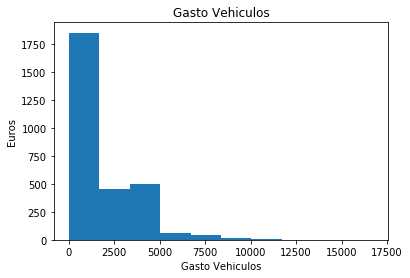

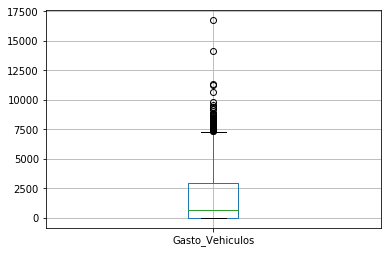

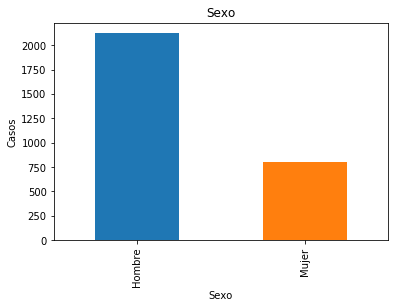

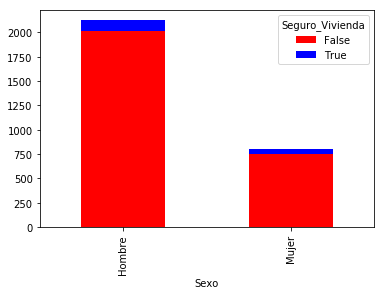

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2926
Data columns (total 28 columns):
ID_Cliente                             2927 non-null object
Fecha_Nacimiento                       2927 non-null object
Fecha_Alta                             2927 non-null object
Sexo                                   2927 non-null object
ID_Zona                                2927 non-null object
Productos_Vida                         2927 non-null int64
Productos_Vehiculos                    2927 non-null int64
Productos_Otros                        2927 non-null int64
Gasto_Vida                             2927 non-null float64
Gasto_Vehiculos                        2927 non-null float64
Gasto_Otros                            2927 non-null float64
Tipo_Familia                           2927 non-null float64
Tipo_Pareja                            2927 non-null float64
Tipo_Soltero                           2927 non-null float64
Educacion_Superior                     2927 non-nu

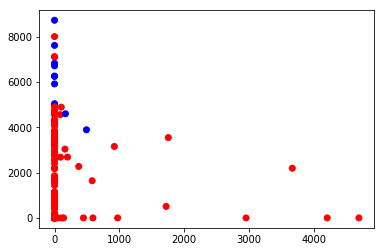

Varianza acumulada explicada por cada componente (tanto por uno):  [0.86426151 0.98018988 0.99803623 0.99879546 0.99916202 0.99934778
 0.99952203 0.99963271 0.99973099 0.99981113]
Varianza acumulada explicada por cada componente (tanto por uno):  [0.86426151 0.98018988]


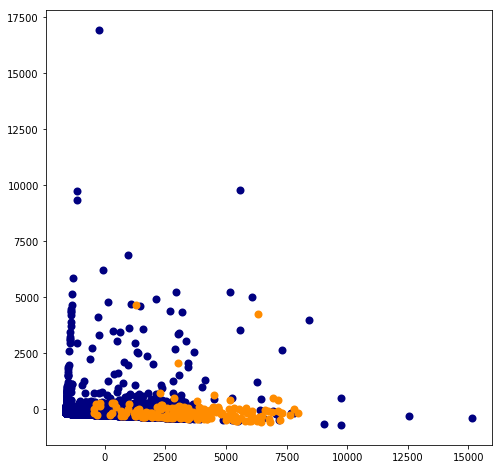

In [1]:
%run 1-2-Preparacion.ipynb

## Selección del modelo

No es evidente cuál es el mejor tipo de modelo para resolver nuestro problema. Por lo tanto, es recomendable empezar con los modelos más sencillos y estables, los modelos lineales, y después probar con otros más expresivos como los perceptrones multicapa. 

Utiliza las variables seleccionadas o transformadas en el apartado anterior y estudia medidas de calidad como la precisión y el "recall" para evaluar cada uno de los modelos. Para ello, se puede dividir el conjunto de datos de entrenamiento en particiones de train y validación (test) de modo que la primera sirva para entrenar los modelos, y la segunda para validar; o bien se puede utilizar una estrategia de cross-validation:

### Separamos en entrenamiento y test

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    variables._get_numeric_data(), targets, test_size=0.3, random_state=42)

datos_path = "./"
clientes_file_2 = "Clientes_test.csv"
zonas_file = "Zonas.csv"

clientes2 = pd.read_csv(os.path.join(datos_path, clientes_file_2), sep='\t')
zonas = pd.read_csv(os.path.join(datos_path, zonas_file), sep='\t')

datos2 = pd.merge(clientes2, zonas, on="ID_Zona", how="inner")

#targets2 = datos2["Seguro_Vivienda"]
#variables2 = datos2.drop(["Seguro_Vivienda"], axis=1, inplace=False)

#mejor trabajar con 1 y 0
y_train = y_train*1
y_test = y_test*1



X_test_2 = datos2._get_numeric_data()

y_test

y_train.sum()/y_train.shape[0]



0.05419921875

Los datos no están balanceados, los que contratan es ~6% del total. Por tanto podemos usar class_weight que tanto en Keras como en Scikitlearn lo tienen. En esta práctica usaremos esto ya que en pruebas realizadas los métodos no aprendía bien la contratación del seguro y por tanto he tenido que recurrir a esta forma.  Existen técnicas más complejas como Near Miss.

Esta técnica nos hará perder Accuracy pero como veremos seremos capaces de acertar mejor los clientes que contratan seguro

In [3]:
#Así podemos genera la variable class_weight que nos ayuda a cambiar los pesos (importancia) de las observaciones en función de la clase
#Aunque algunas funciones sólo funcionan con class_weight = "balanced", luego este código sólo es a modo ilustrativo

from sklearn.utils import class_weight
import numpy as np
class_weight = class_weight.compute_class_weight({1:6,0:1}
                                               ,np.unique(y_train)
                                               ,y_train)

class_weight


array([1., 6.])

In [4]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2048, 23) (879, 23) (2048,) (879,)


# Modelos

## Regresión logística

#### Feauture Selection

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selection = SelectKBest(chi2, k=10)

logreg = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial', C = 1e6, class_weight='balanced') #ponemos un C alto porque no queremos restringir el modelo

modelo_logit = Pipeline([('selection', selection), ('logreg', logreg)]).fit(X_train, y_train)



In [6]:
print( "Accuracy Train: ", modelo_logit.score(X_train,y_train))
print( "Accuracy Test: ", modelo_logit.score(X_test,y_test))

Accuracy Train:  0.81787109375
Accuracy Test:  0.8236632536973834


#### PCA

In [7]:
pca = PCA(n_components=2).fit(variables._get_numeric_data(), targets)

logreg = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial', C = 1e6, class_weight='balanced') #ponemos un C alto porque no queremos restring'balanced'
modelo_logit_pca = Pipeline([('pca', pca), ('logreg', logreg)]).fit(X_train, y_train)



In [8]:
print( "Accuracy Train: ", modelo_logit_pca.score(X_train,y_train))
print( "Accuracy Test: ", modelo_logit_pca.score(X_test,y_test))

Accuracy Train:  0.80859375
Accuracy Test:  0.8145620022753128


Ambos modelos salen con un score bastante similar, algo mayor usando feature selection.

Para terminar calcularemos el recall:

In [9]:
from sklearn.metrics import recall_score

recall_method ='weighted'

print ("Recall Logit Entrenamiento: ", recall_score(y_train, modelo_logit.predict(X_train), average=recall_method))
print ("Recall Logit Test: ", recall_score(y_test, modelo_logit.predict(X_test), average=recall_method))

print ("Recall Logit PCA Entrenamiento: ", recall_score(y_train, modelo_logit_pca.predict(X_train), average=recall_method))
print ("Recall Logit PCA Test: ", recall_score(y_test, modelo_logit_pca.predict(X_test), average=recall_method))

Recall Logit Entrenamiento:  0.81787109375
Recall Logit Test:  0.8236632536973834
Recall Logit PCA Entrenamiento:  0.80859375
Recall Logit PCA Test:  0.8145620022753128


Si hacemos un recall ponderado vemos que ámbos métodos clasifican bastante bien... aparentemente

In [10]:
from sklearn.metrics import recall_score

recall_method = None

print ("Recall Logit Entrenamiento: ", recall_score(y_train, modelo_logit.predict(X_train), average=recall_method))
print ("Recall Logit Test: ", recall_score(y_test, modelo_logit.predict(X_test), average=recall_method))

print ("Recall Logit PCA Entrenamiento: ", recall_score(y_train, modelo_logit_pca.predict(X_train), average=recall_method))
print ("Recall Logit PCA Test: ", recall_score(y_test, modelo_logit_pca.predict(X_test), average=recall_method))

Recall Logit Entrenamiento:  [0.8167269  0.83783784]
Recall Logit Test:  [0.82424242 0.81481481]
Recall Logit PCA Entrenamiento:  [0.80743418 0.82882883]
Recall Logit PCA Test:  [0.81575758 0.7962963 ]


Como la primera fila de Test y Train contiene un False (0), la primera componente es el recall de False, la segunda es True. 
Como vemos en test le cuesta aprender los True, puede ser que aunque hemos balanceados los datos, no es un balanceado estratificado y es posible que por eso en test no tengamos buenos resultados.
Para este propósito habría que recurrir a otro métodos. Esperemos que el Deep Learning nos ayude.

#### Logistic Regression CV con L1 (Lasso)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as randint



param_dist = { "C": randint(0, 1e6) }


logreg = LogisticRegression(random_state=0, solver='liblinear',penalty='l1', class_weight='balanced')

modelo_logit_RS = RandomizedSearchCV(logreg, param_distributions=param_dist, cv=10).fit(X_train, y_train)



In [12]:
recall_method = None

print( "Accuracy Train: ", modelo_logit_RS.score(X_train,y_train))
print( "Accuracy Test: ", modelo_logit_RS.score(X_test,y_test))
print ("Recall Entrenamiento: ", recall_score(y_train, modelo_logit_RS.predict(X_train), average=recall_method))
print ("Recall Test: ", recall_score(y_test, modelo_logit_RS.predict(X_test), average=recall_method))


Accuracy Train:  0.865234375
Accuracy Test:  0.8668941979522184
Recall Entrenamiento:  [0.86473929 0.87387387]
Recall Test:  [0.86787879 0.85185185]


In [13]:
modelo_logit_RS.best_estimator_

LogisticRegression(C=793639, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Notable mejora en Accuracy y Recall, este será el modelo seleccionado para comparar a las redes neuronales en seción 1-4

## Red Neuronal Artificial

Primero debemos escalar los datos

In [14]:
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
import numpy as np

scale = StandardScaler()

X_scale_train = scale.fit_transform(X_train)
X_scale_test = scale.transform(X_test)

#X_scale_train = X_scale_train.reshape((len(X_scale_train), np.prod(X_scale_train.shape[1:])))
#X_scale_test = X_scale_test.reshape((len(X_scale_test), np.prod(X_scale_test.shape[1:])))

#y_cat_train = y_train*1
#y_cat_test = y_test*1

#Necesitamos este paso para poder probar con dos neuronas en la última capa
y_cat_train = to_categorical(y_train.astype(int))
y_cat_test = to_categorical(y_test.astype(int))

#y_cat_train[1:50]
#y_train[1:50]




C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Preparamos algunas funciones de performance

In [15]:
# por lo que veo en las últimas versiones han quitado alguna métrica de Keras, pero en esta ruta están implementadas muchas:
# https://github.com/GeekLiB/keras/blob/master/keras/metrics.py
# tengo dudas si el recall es correcto, pero luego saldremos de dudas cuando veamos las curvas ROC en el siguiente notebook

from keras import backend as K

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score



### Una sola Capa Oculta

In [16]:
from keras.layers import Input, Dense
from keras.models import Model
import tensorflow as tf

tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=4))

x = Input(shape=(23,))
layer = Dense(10, activation='softsign', kernel_initializer='he_uniform')(x)
y = Dense(1, activation='sigmoid',kernel_initializer='he_uniform')(layer)
mlp = Model(x, y)

In [17]:
mlp.compile(optimizer='sgd',
            loss='binary_crossentropy',
            metrics=['accuracy', recall, fbeta_score])

In [18]:
mlp.fit(X_scale_train, y_train,
                epochs=1000,
                batch_size=10,
                shuffle=True,
                validation_data=(X_scale_test, y_test), class_weight='balanced')

Train on 2048 samples, validate on 879 samples
Epoch 1/1000
2048/2048 [==============================] - 0s 195us/step - loss: 0.5853 - acc: 0.7139 - recall: 0.0317 - fbeta_score: 0.0170 - val_loss: 0.4564 - val_acc: 0.8931 - val_recall: 0.0171 - val_fbeta_score: 0.0133
Epoch 2/1000
2048/2048 [==============================] - 0s 106us/step - loss: 0.3732 - acc: 0.9316 - recall: 0.0024 - fbeta_score: 0.0024 - val_loss: 0.3349 - val_acc: 0.9374 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 3/1000
2048/2048 [==============================] - 0s 98us/step - loss: 0.2921 - acc: 0.9458 - recall: 0.0000e+00 - fbeta_score: 0.0000e+00 - val_loss: 0.2818 - val_acc: 0.9374 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 4/1000
2048/2048 [==============================] - 0s 97us/step - loss: 0.2525 - acc: 0.9458 - recall: 0.0000e+00 - fbeta_score: 0.0000e+00 - val_loss: 0.2533 - val_acc: 0.9386 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 5/1000
2048/2

Epoch 36/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.1201 - acc: 0.9570 - recall: 0.1213 - fbeta_score: 0.1270 - val_loss: 0.1440 - val_acc: 0.9397 - val_recall: 0.0607 - val_fbeta_score: 0.0664
Epoch 37/1000
2048/2048 [==============================] - 0s 99us/step - loss: 0.1192 - acc: 0.9570 - recall: 0.1270 - fbeta_score: 0.1302 - val_loss: 0.1431 - val_acc: 0.9397 - val_recall: 0.0607 - val_fbeta_score: 0.0664
Epoch 38/1000
2048/2048 [==============================] - 0s 96us/step - loss: 0.1183 - acc: 0.9570 - recall: 0.1061 - fbeta_score: 0.1150 - val_loss: 0.1424 - val_acc: 0.9386 - val_recall: 0.0607 - val_fbeta_score: 0.0664
Epoch 39/1000
2048/2048 [==============================] - 0s 82us/step - loss: 0.1174 - acc: 0.9570 - recall: 0.1107 - fbeta_score: 0.1188 - val_loss: 0.1417 - val_acc: 0.9397 - val_recall: 0.0645 - val_fbeta_score: 0.0698
Epoch 40/1000
2048/2048 [==============================] - 0s 97us/step - loss: 0.1166 - acc: 0.9580 - r

2048/2048 [==============================] - 0s 109us/step - loss: 0.1030 - acc: 0.9663 - recall: 0.1782 - fbeta_score: 0.1854 - val_loss: 0.1316 - val_acc: 0.9499 - val_recall: 0.1460 - val_fbeta_score: 0.1532
Epoch 73/1000
2048/2048 [==============================] - 0s 128us/step - loss: 0.1028 - acc: 0.9663 - recall: 0.1925 - fbeta_score: 0.1987 - val_loss: 0.1314 - val_acc: 0.9499 - val_recall: 0.1460 - val_fbeta_score: 0.1532
Epoch 74/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.1024 - acc: 0.9663 - recall: 0.1978 - fbeta_score: 0.2065 - val_loss: 0.1317 - val_acc: 0.9499 - val_recall: 0.1346 - val_fbeta_score: 0.1418
Epoch 75/1000
2048/2048 [==============================] - 0s 90us/step - loss: 0.1024 - acc: 0.9668 - recall: 0.1896 - fbeta_score: 0.2000 - val_loss: 0.1314 - val_acc: 0.9499 - val_recall: 0.1460 - val_fbeta_score: 0.1532
Epoch 76/1000
2048/2048 [==============================] - 0s 97us/step - loss: 0.1021 - acc: 0.9668 - recall: 0.191

2048/2048 [==============================] - 0s 89us/step - loss: 0.0980 - acc: 0.9678 - recall: 0.2000 - fbeta_score: 0.2046 - val_loss: 0.1302 - val_acc: 0.9511 - val_recall: 0.1574 - val_fbeta_score: 0.1646
Epoch 109/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0978 - acc: 0.9673 - recall: 0.2108 - fbeta_score: 0.2139 - val_loss: 0.1303 - val_acc: 0.9522 - val_recall: 0.1574 - val_fbeta_score: 0.1646
Epoch 110/1000
2048/2048 [==============================] - 0s 91us/step - loss: 0.0978 - acc: 0.9678 - recall: 0.2108 - fbeta_score: 0.2129 - val_loss: 0.1301 - val_acc: 0.9511 - val_recall: 0.1574 - val_fbeta_score: 0.1646
Epoch 111/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0976 - acc: 0.9678 - recall: 0.2165 - fbeta_score: 0.2227 - val_loss: 0.1301 - val_acc: 0.9522 - val_recall: 0.1574 - val_fbeta_score: 0.1646
Epoch 112/1000
2048/2048 [==============================] - 0s 91us/step - loss: 0.0975 - acc: 0.9683 - recall: 0.1

2048/2048 [==============================] - 0s 87us/step - loss: 0.0943 - acc: 0.9697 - recall: 0.2059 - fbeta_score: 0.2122 - val_loss: 0.1309 - val_acc: 0.9499 - val_recall: 0.1460 - val_fbeta_score: 0.1532
Epoch 145/1000
2048/2048 [==============================] - 0s 90us/step - loss: 0.0942 - acc: 0.9683 - recall: 0.2059 - fbeta_score: 0.2165 - val_loss: 0.1308 - val_acc: 0.9499 - val_recall: 0.1460 - val_fbeta_score: 0.1532
Epoch 146/1000
2048/2048 [==============================] - 0s 96us/step - loss: 0.0941 - acc: 0.9692 - recall: 0.2327 - fbeta_score: 0.2360 - val_loss: 0.1309 - val_acc: 0.9499 - val_recall: 0.1460 - val_fbeta_score: 0.1532
Epoch 147/1000
2048/2048 [==============================] - 0s 82us/step - loss: 0.0940 - acc: 0.9692 - recall: 0.2189 - fbeta_score: 0.2236 - val_loss: 0.1310 - val_acc: 0.9499 - val_recall: 0.1460 - val_fbeta_score: 0.1532
Epoch 148/1000
2048/2048 [==============================] - 0s 90us/step - loss: 0.0939 - acc: 0.9697 - recall: 0.2

2048/2048 [==============================] - 0s 98us/step - loss: 0.0908 - acc: 0.9707 - recall: 0.2185 - fbeta_score: 0.2239 - val_loss: 0.1319 - val_acc: 0.9511 - val_recall: 0.1612 - val_fbeta_score: 0.1680
Epoch 181/1000
2048/2048 [==============================] - 0s 81us/step - loss: 0.0907 - acc: 0.9707 - recall: 0.2051 - fbeta_score: 0.2147 - val_loss: 0.1320 - val_acc: 0.9511 - val_recall: 0.1612 - val_fbeta_score: 0.1680
Epoch 182/1000
2048/2048 [==============================] - 0s 99us/step - loss: 0.0906 - acc: 0.9702 - recall: 0.2401 - fbeta_score: 0.2456 - val_loss: 0.1321 - val_acc: 0.9488 - val_recall: 0.1460 - val_fbeta_score: 0.1532
Epoch 183/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0905 - acc: 0.9697 - recall: 0.2157 - fbeta_score: 0.2212 - val_loss: 0.1320 - val_acc: 0.9511 - val_recall: 0.1612 - val_fbeta_score: 0.1680
Epoch 184/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0904 - acc: 0.9702 - recall: 0.2

2048/2048 [==============================] - 0s 98us/step - loss: 0.0875 - acc: 0.9707 - recall: 0.2253 - fbeta_score: 0.2310 - val_loss: 0.1328 - val_acc: 0.9499 - val_recall: 0.1688 - val_fbeta_score: 0.1760
Epoch 217/1000
2048/2048 [==============================] - 0s 80us/step - loss: 0.0874 - acc: 0.9712 - recall: 0.2246 - fbeta_score: 0.2358 - val_loss: 0.1327 - val_acc: 0.9511 - val_recall: 0.1725 - val_fbeta_score: 0.1794
Epoch 218/1000
2048/2048 [==============================] - 0s 98us/step - loss: 0.0873 - acc: 0.9722 - recall: 0.2334 - fbeta_score: 0.2397 - val_loss: 0.1328 - val_acc: 0.9499 - val_recall: 0.1688 - val_fbeta_score: 0.1760
Epoch 219/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0872 - acc: 0.9722 - recall: 0.2279 - fbeta_score: 0.2373 - val_loss: 0.1328 - val_acc: 0.9511 - val_recall: 0.1744 - val_fbeta_score: 0.1835
Epoch 220/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0871 - acc: 0.9717 - recall: 0.2

2048/2048 [==============================] - 0s 92us/step - loss: 0.0840 - acc: 0.9722 - recall: 0.2401 - fbeta_score: 0.2454 - val_loss: 0.1348 - val_acc: 0.9499 - val_recall: 0.1744 - val_fbeta_score: 0.1813
Epoch 253/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0839 - acc: 0.9727 - recall: 0.2472 - fbeta_score: 0.2521 - val_loss: 0.1348 - val_acc: 0.9499 - val_recall: 0.1744 - val_fbeta_score: 0.1813
Epoch 254/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0838 - acc: 0.9722 - recall: 0.2612 - fbeta_score: 0.2637 - val_loss: 0.1350 - val_acc: 0.9499 - val_recall: 0.1744 - val_fbeta_score: 0.1813
Epoch 255/1000
2048/2048 [==============================] - 0s 91us/step - loss: 0.0838 - acc: 0.9722 - recall: 0.2466 - fbeta_score: 0.2537 - val_loss: 0.1348 - val_acc: 0.9511 - val_recall: 0.1858 - val_fbeta_score: 0.1926
Epoch 256/1000
2048/2048 [==============================] - 0s 95us/step - loss: 0.0837 - acc: 0.9727 - recall: 0.2

2048/2048 [==============================] - 0s 93us/step - loss: 0.0809 - acc: 0.9736 - recall: 0.2494 - fbeta_score: 0.2602 - val_loss: 0.1363 - val_acc: 0.9556 - val_recall: 0.2010 - val_fbeta_score: 0.2097
Epoch 289/1000
2048/2048 [==============================] - 0s 81us/step - loss: 0.0808 - acc: 0.9736 - recall: 0.2441 - fbeta_score: 0.2482 - val_loss: 0.1366 - val_acc: 0.9545 - val_recall: 0.1896 - val_fbeta_score: 0.1983
Epoch 290/1000
2048/2048 [==============================] - 0s 98us/step - loss: 0.0807 - acc: 0.9736 - recall: 0.2507 - fbeta_score: 0.2555 - val_loss: 0.1368 - val_acc: 0.9534 - val_recall: 0.1858 - val_fbeta_score: 0.1949
Epoch 291/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0806 - acc: 0.9736 - recall: 0.2523 - fbeta_score: 0.2593 - val_loss: 0.1366 - val_acc: 0.9534 - val_recall: 0.1858 - val_fbeta_score: 0.1949
Epoch 292/1000
2048/2048 [==============================] - 0s 92us/step - loss: 0.0805 - acc: 0.9736 - recall: 0.2

2048/2048 [==============================] - 0s 95us/step - loss: 0.0776 - acc: 0.9741 - recall: 0.2350 - fbeta_score: 0.2415 - val_loss: 0.1378 - val_acc: 0.9545 - val_recall: 0.2010 - val_fbeta_score: 0.2097
Epoch 325/1000
2048/2048 [==============================] - 0s 83us/step - loss: 0.0775 - acc: 0.9741 - recall: 0.2515 - fbeta_score: 0.2570 - val_loss: 0.1378 - val_acc: 0.9545 - val_recall: 0.2010 - val_fbeta_score: 0.2097
Epoch 326/1000
2048/2048 [==============================] - 0s 96us/step - loss: 0.0774 - acc: 0.9731 - recall: 0.2425 - fbeta_score: 0.2482 - val_loss: 0.1380 - val_acc: 0.9556 - val_recall: 0.2124 - val_fbeta_score: 0.2211
Epoch 327/1000
2048/2048 [==============================] - 0s 81us/step - loss: 0.0773 - acc: 0.9741 - recall: 0.2490 - fbeta_score: 0.2529 - val_loss: 0.1383 - val_acc: 0.9545 - val_recall: 0.2010 - val_fbeta_score: 0.2097
Epoch 328/1000
2048/2048 [==============================] - 0s 97us/step - loss: 0.0773 - acc: 0.9746 - recall: 0.2

2048/2048 [==============================] - 0s 88us/step - loss: 0.0745 - acc: 0.9766 - recall: 0.2651 - fbeta_score: 0.2676 - val_loss: 0.1391 - val_acc: 0.9545 - val_recall: 0.2181 - val_fbeta_score: 0.2287
Epoch 361/1000
2048/2048 [==============================] - 0s 96us/step - loss: 0.0744 - acc: 0.9761 - recall: 0.2734 - fbeta_score: 0.2827 - val_loss: 0.1394 - val_acc: 0.9545 - val_recall: 0.2181 - val_fbeta_score: 0.2287
Epoch 362/1000
2048/2048 [==============================] - 0s 83us/step - loss: 0.0743 - acc: 0.9761 - recall: 0.2669 - fbeta_score: 0.2700 - val_loss: 0.1391 - val_acc: 0.9545 - val_recall: 0.2181 - val_fbeta_score: 0.2287
Epoch 363/1000
2048/2048 [==============================] - 0s 91us/step - loss: 0.0743 - acc: 0.9756 - recall: 0.2743 - fbeta_score: 0.2793 - val_loss: 0.1392 - val_acc: 0.9545 - val_recall: 0.2181 - val_fbeta_score: 0.2287
Epoch 364/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0742 - acc: 0.9766 - recall: 0.2

2048/2048 [==============================] - 0s 94us/step - loss: 0.0718 - acc: 0.9780 - recall: 0.2775 - fbeta_score: 0.2796 - val_loss: 0.1408 - val_acc: 0.9534 - val_recall: 0.2067 - val_fbeta_score: 0.2173
Epoch 397/1000
2048/2048 [==============================] - 0s 82us/step - loss: 0.0718 - acc: 0.9775 - recall: 0.2904 - fbeta_score: 0.2951 - val_loss: 0.1408 - val_acc: 0.9534 - val_recall: 0.2067 - val_fbeta_score: 0.2173
Epoch 398/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0717 - acc: 0.9780 - recall: 0.2550 - fbeta_score: 0.2611 - val_loss: 0.1407 - val_acc: 0.9545 - val_recall: 0.2181 - val_fbeta_score: 0.2287
Epoch 399/1000
2048/2048 [==============================] - 0s 90us/step - loss: 0.0716 - acc: 0.9775 - recall: 0.2669 - fbeta_score: 0.2765 - val_loss: 0.1408 - val_acc: 0.9545 - val_recall: 0.2181 - val_fbeta_score: 0.2287
Epoch 400/1000
2048/2048 [==============================] - 0s 96us/step - loss: 0.0716 - acc: 0.9780 - recall: 0.2

2048/2048 [==============================] - 0s 89us/step - loss: 0.0695 - acc: 0.9790 - recall: 0.2896 - fbeta_score: 0.2928 - val_loss: 0.1426 - val_acc: 0.9534 - val_recall: 0.2067 - val_fbeta_score: 0.2173
Epoch 433/1000
2048/2048 [==============================] - 0s 96us/step - loss: 0.0695 - acc: 0.9790 - recall: 0.2840 - fbeta_score: 0.2926 - val_loss: 0.1422 - val_acc: 0.9545 - val_recall: 0.2181 - val_fbeta_score: 0.2287
Epoch 434/1000
2048/2048 [==============================] - 0s 91us/step - loss: 0.0694 - acc: 0.9785 - recall: 0.2767 - fbeta_score: 0.2869 - val_loss: 0.1419 - val_acc: 0.9545 - val_recall: 0.2181 - val_fbeta_score: 0.2287
Epoch 435/1000
2048/2048 [==============================] - 0s 90us/step - loss: 0.0693 - acc: 0.9790 - recall: 0.2799 - fbeta_score: 0.2824 - val_loss: 0.1423 - val_acc: 0.9545 - val_recall: 0.2181 - val_fbeta_score: 0.2287
Epoch 436/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0693 - acc: 0.9790 - recall: 0.2

2048/2048 [==============================] - 0s 124us/step - loss: 0.0674 - acc: 0.9795 - recall: 0.2909 - fbeta_score: 0.2949 - val_loss: 0.1431 - val_acc: 0.9545 - val_recall: 0.2181 - val_fbeta_score: 0.2287
Epoch 469/1000
2048/2048 [==============================] - 0s 107us/step - loss: 0.0674 - acc: 0.9800 - recall: 0.3034 - fbeta_score: 0.3120 - val_loss: 0.1433 - val_acc: 0.9545 - val_recall: 0.2181 - val_fbeta_score: 0.2287
Epoch 470/1000
2048/2048 [==============================] - 0s 113us/step - loss: 0.0673 - acc: 0.9790 - recall: 0.3263 - fbeta_score: 0.3296 - val_loss: 0.1434 - val_acc: 0.9545 - val_recall: 0.2181 - val_fbeta_score: 0.2287
Epoch 471/1000
2048/2048 [==============================] - 0s 114us/step - loss: 0.0673 - acc: 0.9795 - recall: 0.2979 - fbeta_score: 0.3034 - val_loss: 0.1434 - val_acc: 0.9545 - val_recall: 0.2181 - val_fbeta_score: 0.2287
Epoch 472/1000
2048/2048 [==============================] - 0s 117us/step - loss: 0.0672 - acc: 0.9805 - recall

2048/2048 [==============================] - 0s 100us/step - loss: 0.0653 - acc: 0.9795 - recall: 0.2767 - fbeta_score: 0.2837 - val_loss: 0.1442 - val_acc: 0.9534 - val_recall: 0.2067 - val_fbeta_score: 0.2173
Epoch 505/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0652 - acc: 0.9795 - recall: 0.2791 - fbeta_score: 0.2855 - val_loss: 0.1442 - val_acc: 0.9545 - val_recall: 0.2124 - val_fbeta_score: 0.2230
Epoch 506/1000
2048/2048 [==============================] - 0s 95us/step - loss: 0.0652 - acc: 0.9800 - recall: 0.3050 - fbeta_score: 0.3081 - val_loss: 0.1443 - val_acc: 0.9534 - val_recall: 0.2067 - val_fbeta_score: 0.2173
Epoch 507/1000
2048/2048 [==============================] - 0s 96us/step - loss: 0.0651 - acc: 0.9795 - recall: 0.2743 - fbeta_score: 0.2812 - val_loss: 0.1442 - val_acc: 0.9522 - val_recall: 0.2029 - val_fbeta_score: 0.2139
Epoch 508/1000
2048/2048 [==============================] - 0s 148us/step - loss: 0.0650 - acc: 0.9805 - recall: 0

2048/2048 [==============================] - 0s 97us/step - loss: 0.0632 - acc: 0.9810 - recall: 0.3296 - fbeta_score: 0.3345 - val_loss: 0.1452 - val_acc: 0.9556 - val_recall: 0.2086 - val_fbeta_score: 0.2196
Epoch 541/1000
2048/2048 [==============================] - 0s 96us/step - loss: 0.0632 - acc: 0.9800 - recall: 0.2795 - fbeta_score: 0.2858 - val_loss: 0.1453 - val_acc: 0.9545 - val_recall: 0.2029 - val_fbeta_score: 0.2139
Epoch 542/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0631 - acc: 0.9805 - recall: 0.2946 - fbeta_score: 0.2995 - val_loss: 0.1453 - val_acc: 0.9545 - val_recall: 0.2029 - val_fbeta_score: 0.2139
Epoch 543/1000
2048/2048 [==============================] - ETA: 0s - loss: 0.0597 - acc: 0.9825 - recall: 0.3107 - fbeta_score: 0.31 - 0s 91us/step - loss: 0.0630 - acc: 0.9805 - recall: 0.3149 - fbeta_score: 0.3174 - val_loss: 0.1455 - val_acc: 0.9545 - val_recall: 0.2029 - val_fbeta_score: 0.2139
Epoch 544/1000
2048/2048 [=============

2048/2048 [==============================] - 0s 118us/step - loss: 0.0614 - acc: 0.9805 - recall: 0.2912 - fbeta_score: 0.2948 - val_loss: 0.1477 - val_acc: 0.9534 - val_recall: 0.1991 - val_fbeta_score: 0.2082
Epoch 576/1000
2048/2048 [==============================] - 0s 123us/step - loss: 0.0613 - acc: 0.9805 - recall: 0.2930 - fbeta_score: 0.2998 - val_loss: 0.1476 - val_acc: 0.9534 - val_recall: 0.1991 - val_fbeta_score: 0.2082
Epoch 577/1000
2048/2048 [==============================] - 0s 94us/step - loss: 0.0612 - acc: 0.9805 - recall: 0.2859 - fbeta_score: 0.2926 - val_loss: 0.1476 - val_acc: 0.9534 - val_recall: 0.1991 - val_fbeta_score: 0.2082
Epoch 578/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0612 - acc: 0.9805 - recall: 0.3057 - fbeta_score: 0.3080 - val_loss: 0.1477 - val_acc: 0.9534 - val_recall: 0.1991 - val_fbeta_score: 0.2082
Epoch 579/1000
2048/2048 [==============================] - 0s 108us/step - loss: 0.0611 - acc: 0.9805 - recall: 

2048/2048 [==============================] - 0s 96us/step - loss: 0.0592 - acc: 0.9805 - recall: 0.3115 - fbeta_score: 0.3148 - val_loss: 0.1502 - val_acc: 0.9511 - val_recall: 0.1820 - val_fbeta_score: 0.1892
Epoch 612/1000
2048/2048 [==============================] - 0s 97us/step - loss: 0.0591 - acc: 0.9810 - recall: 0.2835 - fbeta_score: 0.2863 - val_loss: 0.1500 - val_acc: 0.9511 - val_recall: 0.1820 - val_fbeta_score: 0.1892
Epoch 613/1000
2048/2048 [==============================] - 0s 112us/step - loss: 0.0591 - acc: 0.9814 - recall: 0.3418 - fbeta_score: 0.3451 - val_loss: 0.1501 - val_acc: 0.9511 - val_recall: 0.1820 - val_fbeta_score: 0.1892
Epoch 614/1000
2048/2048 [==============================] - 0s 106us/step - loss: 0.0590 - acc: 0.9810 - recall: 0.3245 - fbeta_score: 0.3285 - val_loss: 0.1503 - val_acc: 0.9511 - val_recall: 0.1820 - val_fbeta_score: 0.1892
Epoch 615/1000
2048/2048 [==============================] - 0s 121us/step - loss: 0.0589 - acc: 0.9814 - recall: 

2048/2048 [==============================] - 0s 100us/step - loss: 0.0572 - acc: 0.9814 - recall: 0.3026 - fbeta_score: 0.3024 - val_loss: 0.1526 - val_acc: 0.9511 - val_recall: 0.1820 - val_fbeta_score: 0.1892
Epoch 648/1000
2048/2048 [==============================] - 0s 101us/step - loss: 0.0571 - acc: 0.9829 - recall: 0.3052 - fbeta_score: 0.3053 - val_loss: 0.1527 - val_acc: 0.9511 - val_recall: 0.1820 - val_fbeta_score: 0.1892
Epoch 649/1000
2048/2048 [==============================] - 0s 95us/step - loss: 0.0571 - acc: 0.9819 - recall: 0.3369 - fbeta_score: 0.3421 - val_loss: 0.1528 - val_acc: 0.9511 - val_recall: 0.1820 - val_fbeta_score: 0.1892
Epoch 650/1000
2048/2048 [==============================] - 0s 99us/step - loss: 0.0570 - acc: 0.9814 - recall: 0.3188 - fbeta_score: 0.3237 - val_loss: 0.1526 - val_acc: 0.9511 - val_recall: 0.1820 - val_fbeta_score: 0.1892
Epoch 651/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0570 - acc: 0.9819 - recall: 0

2048/2048 [==============================] - 0s 99us/step - loss: 0.0551 - acc: 0.9829 - recall: 0.3109 - fbeta_score: 0.3096 - val_loss: 0.1547 - val_acc: 0.9522 - val_recall: 0.1877 - val_fbeta_score: 0.1968
Epoch 684/1000
2048/2048 [==============================] - 0s 96us/step - loss: 0.0550 - acc: 0.9824 - recall: 0.3149 - fbeta_score: 0.3148 - val_loss: 0.1544 - val_acc: 0.9522 - val_recall: 0.1877 - val_fbeta_score: 0.1968
Epoch 685/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0550 - acc: 0.9824 - recall: 0.3270 - fbeta_score: 0.3252 - val_loss: 0.1544 - val_acc: 0.9545 - val_recall: 0.2029 - val_fbeta_score: 0.2139
Epoch 686/1000
2048/2048 [==============================] - 0s 91us/step - loss: 0.0549 - acc: 0.9834 - recall: 0.3174 - fbeta_score: 0.3216 - val_loss: 0.1545 - val_acc: 0.9534 - val_recall: 0.1991 - val_fbeta_score: 0.2082
Epoch 687/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0548 - acc: 0.9834 - recall: 0.3

2048/2048 [==============================] - 0s 98us/step - loss: 0.0523 - acc: 0.9849 - recall: 0.3589 - fbeta_score: 0.3589 - val_loss: 0.1544 - val_acc: 0.9511 - val_recall: 0.1877 - val_fbeta_score: 0.1930
Epoch 720/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0523 - acc: 0.9844 - recall: 0.2985 - fbeta_score: 0.3053 - val_loss: 0.1544 - val_acc: 0.9511 - val_recall: 0.1877 - val_fbeta_score: 0.1930
Epoch 721/1000
2048/2048 [==============================] - 0s 96us/step - loss: 0.0522 - acc: 0.9849 - recall: 0.3294 - fbeta_score: 0.3333 - val_loss: 0.1544 - val_acc: 0.9511 - val_recall: 0.1877 - val_fbeta_score: 0.1930
Epoch 722/1000
2048/2048 [==============================] - 0s 93us/step - loss: 0.0521 - acc: 0.9849 - recall: 0.3473 - fbeta_score: 0.3478 - val_loss: 0.1544 - val_acc: 0.9511 - val_recall: 0.1877 - val_fbeta_score: 0.1930
Epoch 723/1000
2048/2048 [==============================] - 0s 96us/step - loss: 0.0520 - acc: 0.9849 - recall: 0.3

2048/2048 [==============================] - 0s 94us/step - loss: 0.0498 - acc: 0.9858 - recall: 0.3040 - fbeta_score: 0.3116 - val_loss: 0.1561 - val_acc: 0.9511 - val_recall: 0.2029 - val_fbeta_score: 0.2101
Epoch 756/1000
2048/2048 [==============================] - 0s 96us/step - loss: 0.0497 - acc: 0.9863 - recall: 0.3359 - fbeta_score: 0.3366 - val_loss: 0.1565 - val_acc: 0.9511 - val_recall: 0.2029 - val_fbeta_score: 0.2101
Epoch 757/1000
2048/2048 [==============================] - 0s 91us/step - loss: 0.0496 - acc: 0.9858 - recall: 0.3320 - fbeta_score: 0.3356 - val_loss: 0.1567 - val_acc: 0.9511 - val_recall: 0.2029 - val_fbeta_score: 0.2101
Epoch 758/1000
2048/2048 [==============================] - 0s 90us/step - loss: 0.0496 - acc: 0.9863 - recall: 0.3734 - fbeta_score: 0.3747 - val_loss: 0.1565 - val_acc: 0.9511 - val_recall: 0.2029 - val_fbeta_score: 0.2101
Epoch 759/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0495 - acc: 0.9858 - recall: 0.3

2048/2048 [==============================] - 0s 98us/step - loss: 0.0478 - acc: 0.9858 - recall: 0.3475 - fbeta_score: 0.3498 - val_loss: 0.1593 - val_acc: 0.9534 - val_recall: 0.2067 - val_fbeta_score: 0.2135
Epoch 792/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0477 - acc: 0.9863 - recall: 0.3467 - fbeta_score: 0.3499 - val_loss: 0.1593 - val_acc: 0.9534 - val_recall: 0.2067 - val_fbeta_score: 0.2135
Epoch 793/1000
2048/2048 [==============================] - 0s 98us/step - loss: 0.0477 - acc: 0.9868 - recall: 0.3573 - fbeta_score: 0.3636 - val_loss: 0.1594 - val_acc: 0.9534 - val_recall: 0.2067 - val_fbeta_score: 0.2135
Epoch 794/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0476 - acc: 0.9868 - recall: 0.3654 - fbeta_score: 0.3708 - val_loss: 0.1595 - val_acc: 0.9534 - val_recall: 0.2067 - val_fbeta_score: 0.2135
Epoch 795/1000
2048/2048 [==============================] - 0s 99us/step - loss: 0.0476 - acc: 0.9858 - recall: 0.3

2048/2048 [==============================] - 0s 99us/step - loss: 0.0461 - acc: 0.9863 - recall: 0.3384 - fbeta_score: 0.3428 - val_loss: 0.1627 - val_acc: 0.9534 - val_recall: 0.2067 - val_fbeta_score: 0.2135
Epoch 828/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0460 - acc: 0.9873 - recall: 0.3475 - fbeta_score: 0.3490 - val_loss: 0.1630 - val_acc: 0.9534 - val_recall: 0.2067 - val_fbeta_score: 0.2135
Epoch 829/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0460 - acc: 0.9863 - recall: 0.3556 - fbeta_score: 0.3545 - val_loss: 0.1633 - val_acc: 0.9534 - val_recall: 0.2067 - val_fbeta_score: 0.2135
Epoch 830/1000
2048/2048 [==============================] - 0s 92us/step - loss: 0.0459 - acc: 0.9863 - recall: 0.3400 - fbeta_score: 0.3436 - val_loss: 0.1636 - val_acc: 0.9534 - val_recall: 0.2067 - val_fbeta_score: 0.2135
Epoch 831/1000
2048/2048 [==============================] - 0s 98us/step - loss: 0.0459 - acc: 0.9868 - recall: 0.3

2048/2048 [==============================] - 0s 93us/step - loss: 0.0445 - acc: 0.9873 - recall: 0.3524 - fbeta_score: 0.3574 - val_loss: 0.1658 - val_acc: 0.9522 - val_recall: 0.2067 - val_fbeta_score: 0.2116
Epoch 864/1000
2048/2048 [==============================] - 0s 106us/step - loss: 0.0445 - acc: 0.9868 - recall: 0.3328 - fbeta_score: 0.3408 - val_loss: 0.1659 - val_acc: 0.9522 - val_recall: 0.2067 - val_fbeta_score: 0.2116
Epoch 865/1000
2048/2048 [==============================] - 0s 147us/step - loss: 0.0444 - acc: 0.9868 - recall: 0.3573 - fbeta_score: 0.3620 - val_loss: 0.1656 - val_acc: 0.9522 - val_recall: 0.1953 - val_fbeta_score: 0.2002
Epoch 866/1000
2048/2048 [==============================] - 0s 87us/step - loss: 0.0444 - acc: 0.9868 - recall: 0.3408 - fbeta_score: 0.3423 - val_loss: 0.1659 - val_acc: 0.9511 - val_recall: 0.1953 - val_fbeta_score: 0.2002
Epoch 867/1000
2048/2048 [==============================] - 0s 95us/step - loss: 0.0444 - acc: 0.9868 - recall: 0

2048/2048 [==============================] - 0s 99us/step - loss: 0.0432 - acc: 0.9873 - recall: 0.3687 - fbeta_score: 0.3711 - val_loss: 0.1685 - val_acc: 0.9499 - val_recall: 0.1915 - val_fbeta_score: 0.1968
Epoch 900/1000
2048/2048 [==============================] - 0s 96us/step - loss: 0.0431 - acc: 0.9868 - recall: 0.3434 - fbeta_score: 0.3447 - val_loss: 0.1685 - val_acc: 0.9511 - val_recall: 0.1953 - val_fbeta_score: 0.2002
Epoch 901/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0431 - acc: 0.9868 - recall: 0.3617 - fbeta_score: 0.3614 - val_loss: 0.1684 - val_acc: 0.9499 - val_recall: 0.1915 - val_fbeta_score: 0.1968
Epoch 902/1000
2048/2048 [==============================] - 0s 97us/step - loss: 0.0431 - acc: 0.9868 - recall: 0.3502 - fbeta_score: 0.3538 - val_loss: 0.1681 - val_acc: 0.9499 - val_recall: 0.1915 - val_fbeta_score: 0.1968
Epoch 903/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0430 - acc: 0.9868 - recall: 0.3

2048/2048 [==============================] - 0s 97us/step - loss: 0.0420 - acc: 0.9868 - recall: 0.3174 - fbeta_score: 0.3219 - val_loss: 0.1703 - val_acc: 0.9511 - val_recall: 0.1915 - val_fbeta_score: 0.1968
Epoch 936/1000
2048/2048 [==============================] - 0s 88us/step - loss: 0.0420 - acc: 0.9868 - recall: 0.3231 - fbeta_score: 0.3278 - val_loss: 0.1704 - val_acc: 0.9511 - val_recall: 0.1915 - val_fbeta_score: 0.1968
Epoch 937/1000
2048/2048 [==============================] - 0s 102us/step - loss: 0.0419 - acc: 0.9868 - recall: 0.3426 - fbeta_score: 0.3415 - val_loss: 0.1705 - val_acc: 0.9511 - val_recall: 0.1915 - val_fbeta_score: 0.1968
Epoch 938/1000
2048/2048 [==============================] - 0s 85us/step - loss: 0.0419 - acc: 0.9868 - recall: 0.3296 - fbeta_score: 0.3341 - val_loss: 0.1707 - val_acc: 0.9511 - val_recall: 0.1915 - val_fbeta_score: 0.1968
Epoch 939/1000
2048/2048 [==============================] - 0s 98us/step - loss: 0.0418 - acc: 0.9873 - recall: 0.

2048/2048 [==============================] - 0s 94us/step - loss: 0.0409 - acc: 0.9868 - recall: 0.3524 - fbeta_score: 0.3561 - val_loss: 0.1719 - val_acc: 0.9499 - val_recall: 0.1972 - val_fbeta_score: 0.2025
Epoch 972/1000
2048/2048 [==============================] - 0s 89us/step - loss: 0.0409 - acc: 0.9878 - recall: 0.3499 - fbeta_score: 0.3522 - val_loss: 0.1719 - val_acc: 0.9499 - val_recall: 0.1972 - val_fbeta_score: 0.2025
Epoch 973/1000
2048/2048 [==============================] - 0s 97us/step - loss: 0.0409 - acc: 0.9888 - recall: 0.3182 - fbeta_score: 0.3242 - val_loss: 0.1721 - val_acc: 0.9499 - val_recall: 0.1972 - val_fbeta_score: 0.2025
Epoch 974/1000
2048/2048 [==============================] - 0s 83us/step - loss: 0.0408 - acc: 0.9873 - recall: 0.3359 - fbeta_score: 0.3352 - val_loss: 0.1724 - val_acc: 0.9499 - val_recall: 0.1972 - val_fbeta_score: 0.2025
Epoch 975/1000
2048/2048 [==============================] - 0s 98us/step - loss: 0.0408 - acc: 0.9863 - recall: 0.3

In [19]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


Con una sola capa oculta de 10 unidades conseguimos una precisión mayor que con los modelos basados en regresión logística, pero empora bastante el recall. 

Como función de activación de las capas ocultas usamos "softsign" ya que nos ha dado mejores resultados que "relu", la capa de salida al ser de clasificación usa una función de activación "sigmoid"

Para inicializar usamos "he_uniform" que nos ayuda con el "Vanishing Gradient"

Para los siguientes modelos tambien escalaremos los pesos de las capas ocultas para evitar el Covariate Shift



### Multi Capa (Deep)

In [20]:
from keras.layers import Input, Dense
from keras.models import Model
import tensorflow as tf
from keras.layers.normalization import BatchNormalization

tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=4))

x = Input(shape=(23,))
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform')(x)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform')(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform')(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform')(layer)
layer = BatchNormalization()(layer)
y = Dense(1, activation='sigmoid',kernel_initializer='he_uniform')(layer)
mlp2 = Model(x, y)

In [21]:
mlp2.compile(optimizer='sgd',
            loss='binary_crossentropy',
            metrics=['accuracy', recall, fbeta_score])

In [22]:
mlp2.fit(X_scale_train, y_train,
                epochs=1000,
                batch_size=10,
                shuffle=True,
                validation_split=0.1, class_weight='balanced')

Train on 1843 samples, validate on 205 samples
Epoch 1/1000
1843/1843 [==============================] - 1s 798us/step - loss: 0.4630 - acc: 0.8014 - recall: 0.1881 - fbeta_score: 0.1332 - val_loss: 0.2829 - val_acc: 0.9366 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 2/1000
1843/1843 [==============================] - 0s 214us/step - loss: 0.2305 - acc: 0.9468 - recall: 0.0868 - fbeta_score: 0.0940 - val_loss: 0.2035 - val_acc: 0.9463 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 3/1000
1843/1843 [==============================] - 0s 206us/step - loss: 0.1777 - acc: 0.9533 - recall: 0.0959 - fbeta_score: 0.1002 - val_loss: 0.1823 - val_acc: 0.9415 - val_recall: 0.0244 - val_fbeta_score: 0.0325
Epoch 4/1000
1843/1843 [==============================] - 0s 208us/step - loss: 0.1555 - acc: 0.9490 - recall: 0.0868 - fbeta_score: 0.0913 - val_loss: 0.1812 - val_acc: 0.9415 - val_recall: 0.0244 - val_fbeta_score: 0.0325
Epoch 5/1000
1843/1843 [==============================] -

1843/1843 [==============================] - 0s 207us/step - loss: 0.0489 - acc: 0.9826 - recall: 0.3509 - fbeta_score: 0.3588 - val_loss: 0.1540 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 38/1000
1843/1843 [==============================] - 1s 337us/step - loss: 0.0504 - acc: 0.9843 - recall: 0.3572 - fbeta_score: 0.3599 - val_loss: 0.1698 - val_acc: 0.9366 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 39/1000
1843/1843 [==============================] - 0s 249us/step - loss: 0.0435 - acc: 0.9843 - recall: 0.3445 - fbeta_score: 0.3491 - val_loss: 0.1690 - val_acc: 0.9415 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 40/1000
1843/1843 [==============================] - 0s 233us/step - loss: 0.0519 - acc: 0.9810 - recall: 0.3256 - fbeta_score: 0.3326 - val_loss: 0.1900 - val_acc: 0.9366 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 41/1000
1843/1843 [==============================] - 0s 260us/step - loss: 0.0597 - acc: 0.9761 - recall: 0.

1843/1843 [==============================] - 0s 179us/step - loss: 0.0249 - acc: 0.9908 - recall: 0.4015 - fbeta_score: 0.4051 - val_loss: 0.1936 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 74/1000
1843/1843 [==============================] - 0s 174us/step - loss: 0.0314 - acc: 0.9886 - recall: 0.3798 - fbeta_score: 0.3834 - val_loss: 0.2288 - val_acc: 0.9415 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 75/1000
1843/1843 [==============================] - 0s 178us/step - loss: 0.0349 - acc: 0.9875 - recall: 0.3566 - fbeta_score: 0.3597 - val_loss: 0.2051 - val_acc: 0.9463 - val_recall: 0.0976 - val_fbeta_score: 0.1138
Epoch 76/1000
1843/1843 [==============================] - 0s 170us/step - loss: 0.0328 - acc: 0.9886 - recall: 0.3586 - fbeta_score: 0.3630 - val_loss: 0.1964 - val_acc: 0.9512 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 77/1000
1843/1843 [==============================] - 0s 179us/step - loss: 0.0274 - acc: 0.9891 - recall: 0.

1843/1843 [==============================] - 0s 170us/step - loss: 0.0283 - acc: 0.9875 - recall: 0.3473 - fbeta_score: 0.3476 - val_loss: 0.2174 - val_acc: 0.9415 - val_recall: 0.0488 - val_fbeta_score: 0.0650
Epoch 110/1000
1843/1843 [==============================] - 0s 178us/step - loss: 0.0222 - acc: 0.9940 - recall: 0.3789 - fbeta_score: 0.3825 - val_loss: 0.2104 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 111/1000
1843/1843 [==============================] - 0s 174us/step - loss: 0.0164 - acc: 0.9940 - recall: 0.4106 - fbeta_score: 0.4147 - val_loss: 0.1943 - val_acc: 0.9463 - val_recall: 0.0976 - val_fbeta_score: 0.1138
Epoch 112/1000
1843/1843 [==============================] - 0s 178us/step - loss: 0.0333 - acc: 0.9859 - recall: 0.3549 - fbeta_score: 0.3612 - val_loss: 0.2138 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 113/1000
1843/1843 [==============================] - 0s 170us/step - loss: 0.0168 - acc: 0.9940 - recall

1843/1843 [==============================] - 0s 180us/step - loss: 0.0180 - acc: 0.9951 - recall: 0.4088 - fbeta_score: 0.4120 - val_loss: 0.2071 - val_acc: 0.9415 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 146/1000
1843/1843 [==============================] - 0s 170us/step - loss: 0.0232 - acc: 0.9919 - recall: 0.3916 - fbeta_score: 0.3950 - val_loss: 0.2051 - val_acc: 0.9366 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 147/1000
1843/1843 [==============================] - 0s 179us/step - loss: 0.0230 - acc: 0.9891 - recall: 0.3708 - fbeta_score: 0.3733 - val_loss: 0.2119 - val_acc: 0.9317 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 148/1000
1843/1843 [==============================] - 0s 171us/step - loss: 0.0191 - acc: 0.9919 - recall: 0.4113 - fbeta_score: 0.4122 - val_loss: 0.1930 - val_acc: 0.9317 - val_recall: 0.0976 - val_fbeta_score: 0.1138
Epoch 149/1000
1843/1843 [==============================] - 0s 181us/step - loss: 0.0285 - acc: 0.9886 - recall

1843/1843 [==============================] - 0s 170us/step - loss: 0.0209 - acc: 0.9935 - recall: 0.4051 - fbeta_score: 0.4095 - val_loss: 0.2009 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 182/1000
1843/1843 [==============================] - 0s 179us/step - loss: 0.0175 - acc: 0.9946 - recall: 0.4160 - fbeta_score: 0.4203 - val_loss: 0.2261 - val_acc: 0.9366 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 183/1000
1843/1843 [==============================] - 0s 171us/step - loss: 0.0284 - acc: 0.9902 - recall: 0.4074 - fbeta_score: 0.4089 - val_loss: 0.2029 - val_acc: 0.9366 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 184/1000
1843/1843 [==============================] - 0s 183us/step - loss: 0.0194 - acc: 0.9951 - recall: 0.4097 - fbeta_score: 0.4106 - val_loss: 0.2169 - val_acc: 0.9415 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 185/1000
1843/1843 [==============================] - 0s 178us/step - loss: 0.0143 - acc: 0.9946 - recall

1843/1843 [==============================] - 0s 178us/step - loss: 0.0154 - acc: 0.9929 - recall: 0.3997 - fbeta_score: 0.4022 - val_loss: 0.2292 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 218/1000
1843/1843 [==============================] - 0s 174us/step - loss: 0.0151 - acc: 0.9946 - recall: 0.3836 - fbeta_score: 0.3852 - val_loss: 0.2420 - val_acc: 0.9366 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 219/1000
1843/1843 [==============================] - 0s 178us/step - loss: 0.0137 - acc: 0.9957 - recall: 0.3943 - fbeta_score: 0.3986 - val_loss: 0.2279 - val_acc: 0.9512 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 220/1000
1843/1843 [==============================] - 0s 170us/step - loss: 0.0106 - acc: 0.9957 - recall: 0.3744 - fbeta_score: 0.3744 - val_loss: 0.2380 - val_acc: 0.9415 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 221/1000
1843/1843 [==============================] - 0s 187us/step - loss: 0.0147 - acc: 0.9957 - recall

1843/1843 [==============================] - 0s 173us/step - loss: 0.0107 - acc: 0.9962 - recall: 0.4042 - fbeta_score: 0.4051 - val_loss: 0.2670 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 254/1000
1843/1843 [==============================] - 0s 178us/step - loss: 0.0115 - acc: 0.9967 - recall: 0.4303 - fbeta_score: 0.4321 - val_loss: 0.2887 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 255/1000
1843/1843 [==============================] - 0s 175us/step - loss: 0.0121 - acc: 0.9962 - recall: 0.3880 - fbeta_score: 0.3889 - val_loss: 0.2613 - val_acc: 0.9463 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 256/1000
1843/1843 [==============================] - 0s 178us/step - loss: 0.0141 - acc: 0.9962 - recall: 0.3852 - fbeta_score: 0.3889 - val_loss: 0.3034 - val_acc: 0.9415 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 257/1000
1843/1843 [==============================] - 0s 172us/step - loss: 0.0153 - acc: 0.9957 - recall

1843/1843 [==============================] - 0s 215us/step - loss: 0.0092 - acc: 0.9978 - recall: 0.4088 - fbeta_score: 0.4102 - val_loss: 0.2297 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 290/1000
1843/1843 [==============================] - 0s 201us/step - loss: 0.0083 - acc: 0.9978 - recall: 0.4205 - fbeta_score: 0.4214 - val_loss: 0.2744 - val_acc: 0.9415 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 291/1000
1843/1843 [==============================] - 0s 203us/step - loss: 0.0116 - acc: 0.9973 - recall: 0.4232 - fbeta_score: 0.4250 - val_loss: 0.2867 - val_acc: 0.9366 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 292/1000
1843/1843 [==============================] - 0s 199us/step - loss: 0.0082 - acc: 0.9957 - recall: 0.4241 - fbeta_score: 0.4239 - val_loss: 0.3114 - val_acc: 0.9268 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 293/1000
1843/1843 [==============================] - 0s 208us/step - loss: 0.0069 - acc: 0.9973 - recall

1843/1843 [==============================] - 0s 203us/step - loss: 0.0120 - acc: 0.9973 - recall: 0.4214 - fbeta_score: 0.4221 - val_loss: 0.2303 - val_acc: 0.9512 - val_recall: 0.1951 - val_fbeta_score: 0.2033
Epoch 326/1000
1843/1843 [==============================] - 0s 208us/step - loss: 0.0131 - acc: 0.9973 - recall: 0.3843 - fbeta_score: 0.3867 - val_loss: 0.2602 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 327/1000
1843/1843 [==============================] - 0s 200us/step - loss: 0.0090 - acc: 0.9962 - recall: 0.4160 - fbeta_score: 0.4149 - val_loss: 0.2980 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 328/1000
1843/1843 [==============================] - 0s 217us/step - loss: 0.0100 - acc: 0.9957 - recall: 0.4250 - fbeta_score: 0.4283 - val_loss: 0.2735 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 329/1000
1843/1843 [==============================] - 0s 207us/step - loss: 0.0072 - acc: 0.9978 - recall

1843/1843 [==============================] - 0s 236us/step - loss: 0.0112 - acc: 0.9962 - recall: 0.4232 - fbeta_score: 0.4267 - val_loss: 0.2475 - val_acc: 0.9512 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 362/1000
1843/1843 [==============================] - 0s 239us/step - loss: 0.0084 - acc: 0.9989 - recall: 0.4205 - fbeta_score: 0.4214 - val_loss: 0.2807 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 363/1000
1843/1843 [==============================] - 0s 245us/step - loss: 0.0144 - acc: 0.9962 - recall: 0.4078 - fbeta_score: 0.4095 - val_loss: 0.2279 - val_acc: 0.9610 - val_recall: 0.2439 - val_fbeta_score: 0.2602
Epoch 364/1000
1843/1843 [==============================] - 0s 251us/step - loss: 0.0166 - acc: 0.9946 - recall: 0.3861 - fbeta_score: 0.3878 - val_loss: 0.2276 - val_acc: 0.9463 - val_recall: 0.0976 - val_fbeta_score: 0.1138
Epoch 365/1000
1843/1843 [==============================] - 0s 244us/step - loss: 0.0105 - acc: 0.9951 - recall

1843/1843 [==============================] - 0s 209us/step - loss: 0.0066 - acc: 0.9978 - recall: 0.4368 - fbeta_score: 0.4395 - val_loss: 0.2730 - val_acc: 0.9463 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 398/1000
1843/1843 [==============================] - 0s 199us/step - loss: 0.0121 - acc: 0.9957 - recall: 0.4133 - fbeta_score: 0.4149 - val_loss: 0.3195 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 399/1000
1843/1843 [==============================] - 0s 207us/step - loss: 0.0032 - acc: 0.9995 - recall: 0.4449 - fbeta_score: 0.4449 - val_loss: 0.3012 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 400/1000
1843/1843 [==============================] - 0s 204us/step - loss: 0.0210 - acc: 0.9940 - recall: 0.3885 - fbeta_score: 0.3929 - val_loss: 0.3247 - val_acc: 0.9415 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 401/1000
1843/1843 [==============================] - 0s 202us/step - loss: 0.0188 - acc: 0.9951 - recall

1843/1843 [==============================] - 0s 206us/step - loss: 0.0108 - acc: 0.9967 - recall: 0.4047 - fbeta_score: 0.4076 - val_loss: 0.2516 - val_acc: 0.9463 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 434/1000
1843/1843 [==============================] - 0s 199us/step - loss: 0.0115 - acc: 0.9951 - recall: 0.3735 - fbeta_score: 0.3776 - val_loss: 0.2580 - val_acc: 0.9415 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 435/1000
1843/1843 [==============================] - 0s 203us/step - loss: 0.0105 - acc: 0.9973 - recall: 0.4078 - fbeta_score: 0.4077 - val_loss: 0.2857 - val_acc: 0.9415 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 436/1000
1843/1843 [==============================] - 0s 229us/step - loss: 0.0075 - acc: 0.9978 - recall: 0.4133 - fbeta_score: 0.4149 - val_loss: 0.3152 - val_acc: 0.9366 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 437/1000
1843/1843 [==============================] - 0s 254us/step - loss: 0.0115 - acc: 0.9973 - recall

Epoch 469/1000
1843/1843 [==============================] - 1s 347us/step - loss: 0.0056 - acc: 0.9995 - recall: 0.4069 - fbeta_score: 0.4069 - val_loss: 0.2714 - val_acc: 0.9463 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 470/1000
1843/1843 [==============================] - 0s 208us/step - loss: 0.0076 - acc: 0.9984 - recall: 0.4476 - fbeta_score: 0.4485 - val_loss: 0.2334 - val_acc: 0.9512 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 471/1000
1843/1843 [==============================] - 0s 209us/step - loss: 0.0080 - acc: 0.9978 - recall: 0.4214 - fbeta_score: 0.4203 - val_loss: 0.2530 - val_acc: 0.9463 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 472/1000
1843/1843 [==============================] - 0s 206us/step - loss: 0.0060 - acc: 0.9978 - recall: 0.4422 - fbeta_score: 0.4395 - val_loss: 0.2503 - val_acc: 0.9463 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 473/1000
1843/1843 [==============================] - 0s 222us/step - loss: 0.0137 - acc: 

1843/1843 [==============================] - 0s 208us/step - loss: 0.0164 - acc: 0.9940 - recall: 0.3952 - fbeta_score: 0.3970 - val_loss: 0.2756 - val_acc: 0.9366 - val_recall: 0.0976 - val_fbeta_score: 0.1138
Epoch 506/1000
1843/1843 [==============================] - 0s 201us/step - loss: 0.0153 - acc: 0.9951 - recall: 0.3825 - fbeta_score: 0.3851 - val_loss: 0.2553 - val_acc: 0.9463 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 507/1000
1843/1843 [==============================] - 0s 199us/step - loss: 0.0078 - acc: 0.9978 - recall: 0.4051 - fbeta_score: 0.4041 - val_loss: 0.2722 - val_acc: 0.9561 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 508/1000
1843/1843 [==============================] - 0s 208us/step - loss: 0.0096 - acc: 0.9973 - recall: 0.4350 - fbeta_score: 0.4384 - val_loss: 0.2581 - val_acc: 0.9610 - val_recall: 0.2439 - val_fbeta_score: 0.2602
Epoch 509/1000
1843/1843 [==============================] - 0s 208us/step - loss: 0.0052 - acc: 0.9989 - recall

1843/1843 [==============================] - 0s 210us/step - loss: 0.0188 - acc: 0.9940 - recall: 0.4142 - fbeta_score: 0.4169 - val_loss: 0.2645 - val_acc: 0.9463 - val_recall: 0.0976 - val_fbeta_score: 0.1138
Epoch 542/1000
1843/1843 [==============================] - 0s 205us/step - loss: 0.0132 - acc: 0.9946 - recall: 0.3762 - fbeta_score: 0.3796 - val_loss: 0.2709 - val_acc: 0.9512 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 543/1000
1843/1843 [==============================] - 0s 203us/step - loss: 0.0108 - acc: 0.9951 - recall: 0.4113 - fbeta_score: 0.4140 - val_loss: 0.3037 - val_acc: 0.9415 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 544/1000
1843/1843 [==============================] - 0s 209us/step - loss: 0.0087 - acc: 0.9978 - recall: 0.4124 - fbeta_score: 0.4142 - val_loss: 0.2236 - val_acc: 0.9463 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 545/1000
1843/1843 [==============================] - 0s 203us/step - loss: 0.0124 - acc: 0.9962 - recall

1843/1843 [==============================] - 0s 205us/step - loss: 0.0157 - acc: 0.9951 - recall: 0.3684 - fbeta_score: 0.3684 - val_loss: 0.2393 - val_acc: 0.9463 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 578/1000
1843/1843 [==============================] - 0s 199us/step - loss: 0.0064 - acc: 0.9984 - recall: 0.4323 - fbeta_score: 0.4312 - val_loss: 0.2634 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 579/1000
1843/1843 [==============================] - 0s 208us/step - loss: 0.0026 - acc: 1.0000 - recall: 0.4178 - fbeta_score: 0.4178 - val_loss: 0.2534 - val_acc: 0.9512 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 580/1000
1843/1843 [==============================] - 0s 208us/step - loss: 0.0039 - acc: 0.9989 - recall: 0.4232 - fbeta_score: 0.4232 - val_loss: 0.2840 - val_acc: 0.9415 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 581/1000
1843/1843 [==============================] - 0s 208us/step - loss: 0.0062 - acc: 0.9978 - recall

1843/1843 [==============================] - 0s 203us/step - loss: 0.0157 - acc: 0.9940 - recall: 0.3812 - fbeta_score: 0.3872 - val_loss: 0.2298 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 614/1000
1843/1843 [==============================] - 0s 206us/step - loss: 0.0048 - acc: 0.9989 - recall: 0.4666 - fbeta_score: 0.4666 - val_loss: 0.2659 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 615/1000
1843/1843 [==============================] - 0s 201us/step - loss: 0.0045 - acc: 0.9984 - recall: 0.4051 - fbeta_score: 0.4059 - val_loss: 0.2719 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 616/1000
1843/1843 [==============================] - 0s 208us/step - loss: 0.0059 - acc: 0.9984 - recall: 0.4431 - fbeta_score: 0.4438 - val_loss: 0.2648 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 617/1000
1843/1843 [==============================] - 0s 211us/step - loss: 0.0038 - acc: 0.9984 - recall

1843/1843 [==============================] - 0s 246us/step - loss: 0.0053 - acc: 0.9978 - recall: 0.4176 - fbeta_score: 0.4183 - val_loss: 0.2707 - val_acc: 0.9415 - val_recall: 0.0976 - val_fbeta_score: 0.1138
Epoch 650/1000
1843/1843 [==============================] - 0s 239us/step - loss: 0.0083 - acc: 0.9973 - recall: 0.3825 - fbeta_score: 0.3855 - val_loss: 0.2548 - val_acc: 0.9366 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 651/1000
1843/1843 [==============================] - 0s 239us/step - loss: 0.0106 - acc: 0.9967 - recall: 0.4205 - fbeta_score: 0.4214 - val_loss: 0.3040 - val_acc: 0.9415 - val_recall: 0.2439 - val_fbeta_score: 0.2602
Epoch 652/1000
1843/1843 [==============================] - 0s 236us/step - loss: 0.0075 - acc: 0.9984 - recall: 0.4133 - fbeta_score: 0.4131 - val_loss: 0.2701 - val_acc: 0.9512 - val_recall: 0.2195 - val_fbeta_score: 0.2276
Epoch 653/1000
1843/1843 [==============================] - 0s 231us/step - loss: 0.0076 - acc: 0.9973 - recall

Epoch 685/1000
1843/1843 [==============================] - 0s 205us/step - loss: 0.0038 - acc: 0.9984 - recall: 0.4051 - fbeta_score: 0.4059 - val_loss: 0.3267 - val_acc: 0.9415 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 686/1000
1843/1843 [==============================] - 0s 200us/step - loss: 0.0079 - acc: 0.9973 - recall: 0.4083 - fbeta_score: 0.4098 - val_loss: 0.3382 - val_acc: 0.9415 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 687/1000
1843/1843 [==============================] - 0s 207us/step - loss: 0.0038 - acc: 0.9984 - recall: 0.4151 - fbeta_score: 0.4160 - val_loss: 0.3140 - val_acc: 0.9415 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 688/1000
1843/1843 [==============================] - 0s 201us/step - loss: 0.0037 - acc: 0.9995 - recall: 0.3825 - fbeta_score: 0.3834 - val_loss: 0.3174 - val_acc: 0.9366 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 689/1000
1843/1843 [==============================] - 0s 207us/step - loss: 0.0049 - acc: 

1843/1843 [==============================] - 0s 204us/step - loss: 0.0088 - acc: 0.9973 - recall: 0.4205 - fbeta_score: 0.4232 - val_loss: 0.2543 - val_acc: 0.9463 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 722/1000
1843/1843 [==============================] - 0s 200us/step - loss: 0.0078 - acc: 0.9984 - recall: 0.4232 - fbeta_score: 0.4232 - val_loss: 0.2938 - val_acc: 0.9366 - val_recall: 0.0976 - val_fbeta_score: 0.1138
Epoch 723/1000
1843/1843 [==============================] - 0s 199us/step - loss: 0.0090 - acc: 0.9967 - recall: 0.4205 - fbeta_score: 0.4178 - val_loss: 0.2490 - val_acc: 0.9561 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 724/1000
1843/1843 [==============================] - 0s 205us/step - loss: 0.0086 - acc: 0.9973 - recall: 0.4259 - fbeta_score: 0.4286 - val_loss: 0.2736 - val_acc: 0.9463 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 725/1000
1843/1843 [==============================] - 0s 202us/step - loss: 0.0065 - acc: 0.9984 - recall

1843/1843 [==============================] - 0s 204us/step - loss: 0.0168 - acc: 0.9946 - recall: 0.4124 - fbeta_score: 0.4124 - val_loss: 0.2809 - val_acc: 0.9366 - val_recall: 0.0488 - val_fbeta_score: 0.0488
Epoch 758/1000
1843/1843 [==============================] - 0s 200us/step - loss: 0.0145 - acc: 0.9962 - recall: 0.4097 - fbeta_score: 0.4106 - val_loss: 0.2621 - val_acc: 0.9415 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 759/1000
1843/1843 [==============================] - 0s 208us/step - loss: 0.0133 - acc: 0.9951 - recall: 0.4314 - fbeta_score: 0.4359 - val_loss: 0.3029 - val_acc: 0.9366 - val_recall: 0.0488 - val_fbeta_score: 0.0488
Epoch 760/1000
1843/1843 [==============================] - 0s 199us/step - loss: 0.0214 - acc: 0.9929 - recall: 0.3898 - fbeta_score: 0.3939 - val_loss: 0.2403 - val_acc: 0.9659 - val_recall: 0.3659 - val_fbeta_score: 0.3577
Epoch 761/1000
1843/1843 [==============================] - 0s 205us/step - loss: 0.0155 - acc: 0.9924 - recall

1843/1843 [==============================] - 0s 206us/step - loss: 0.0116 - acc: 0.9957 - recall: 0.3923 - fbeta_score: 0.3959 - val_loss: 0.2433 - val_acc: 0.9659 - val_recall: 0.2927 - val_fbeta_score: 0.3089
Epoch 794/1000
1843/1843 [==============================] - 0s 208us/step - loss: 0.0080 - acc: 0.9973 - recall: 0.4422 - fbeta_score: 0.4431 - val_loss: 0.2606 - val_acc: 0.9463 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 795/1000
1843/1843 [==============================] - 0s 202us/step - loss: 0.0120 - acc: 0.9957 - recall: 0.4088 - fbeta_score: 0.4102 - val_loss: 0.2895 - val_acc: 0.9415 - val_recall: 0.0976 - val_fbeta_score: 0.0976
Epoch 796/1000
1843/1843 [==============================] - 0s 204us/step - loss: 0.0070 - acc: 0.9967 - recall: 0.4142 - fbeta_score: 0.4156 - val_loss: 0.2848 - val_acc: 0.9415 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 797/1000
1843/1843 [==============================] - 0s 198us/step - loss: 0.0062 - acc: 0.9989 - recall

1843/1843 [==============================] - 0s 213us/step - loss: 0.0056 - acc: 0.9984 - recall: 0.4232 - fbeta_score: 0.4214 - val_loss: 0.2944 - val_acc: 0.9463 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 830/1000
1843/1843 [==============================] - 0s 203us/step - loss: 0.0097 - acc: 0.9967 - recall: 0.4013 - fbeta_score: 0.4039 - val_loss: 0.2738 - val_acc: 0.9561 - val_recall: 0.2683 - val_fbeta_score: 0.2764
Epoch 831/1000
1843/1843 [==============================] - 0s 204us/step - loss: 0.0058 - acc: 0.9984 - recall: 0.4285 - fbeta_score: 0.4292 - val_loss: 0.2879 - val_acc: 0.9610 - val_recall: 0.2683 - val_fbeta_score: 0.2764
Epoch 832/1000
1843/1843 [==============================] - 0s 205us/step - loss: 0.0097 - acc: 0.9973 - recall: 0.3925 - fbeta_score: 0.3939 - val_loss: 0.3083 - val_acc: 0.9512 - val_recall: 0.1951 - val_fbeta_score: 0.1951
Epoch 833/1000
1843/1843 [==============================] - 0s 201us/step - loss: 0.0110 - acc: 0.9962 - recall

1843/1843 [==============================] - 0s 216us/step - loss: 0.0070 - acc: 0.9973 - recall: 0.3889 - fbeta_score: 0.3914 - val_loss: 0.2720 - val_acc: 0.9463 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 866/1000
1843/1843 [==============================] - 0s 197us/step - loss: 0.0096 - acc: 0.9967 - recall: 0.4133 - fbeta_score: 0.4131 - val_loss: 0.2876 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 867/1000
1843/1843 [==============================] - 0s 209us/step - loss: 0.0098 - acc: 0.9967 - recall: 0.4069 - fbeta_score: 0.4104 - val_loss: 0.3048 - val_acc: 0.9463 - val_recall: 0.1463 - val_fbeta_score: 0.1463
Epoch 868/1000
1843/1843 [==============================] - 0s 207us/step - loss: 0.0079 - acc: 0.9967 - recall: 0.3789 - fbeta_score: 0.3831 - val_loss: 0.2234 - val_acc: 0.9659 - val_recall: 0.2927 - val_fbeta_score: 0.3089
Epoch 869/1000
1843/1843 [==============================] - 0s 204us/step - loss: 0.0114 - acc: 0.9957 - recall

1843/1843 [==============================] - 0s 207us/step - loss: 0.0129 - acc: 0.9957 - recall: 0.4259 - fbeta_score: 0.4250 - val_loss: 0.2468 - val_acc: 0.9415 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 902/1000
1843/1843 [==============================] - 0s 203us/step - loss: 0.0097 - acc: 0.9962 - recall: 0.4024 - fbeta_score: 0.4041 - val_loss: 0.2321 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 903/1000
1843/1843 [==============================] - 0s 200us/step - loss: 0.0091 - acc: 0.9973 - recall: 0.4178 - fbeta_score: 0.4178 - val_loss: 0.2720 - val_acc: 0.9463 - val_recall: 0.0976 - val_fbeta_score: 0.1138
Epoch 904/1000
1843/1843 [==============================] - 0s 217us/step - loss: 0.0124 - acc: 0.9962 - recall: 0.4042 - fbeta_score: 0.4033 - val_loss: 0.2360 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 905/1000
1843/1843 [==============================] - 0s 207us/step - loss: 0.0180 - acc: 0.9929 - recall

1843/1843 [==============================] - 0s 257us/step - loss: 0.0109 - acc: 0.9967 - recall: 0.4133 - fbeta_score: 0.4149 - val_loss: 0.2816 - val_acc: 0.9415 - val_recall: 0.0976 - val_fbeta_score: 0.0976
Epoch 938/1000
1843/1843 [==============================] - 0s 257us/step - loss: 0.0115 - acc: 0.9957 - recall: 0.4104 - fbeta_score: 0.4118 - val_loss: 0.2265 - val_acc: 0.9512 - val_recall: 0.1951 - val_fbeta_score: 0.1951
Epoch 939/1000
1843/1843 [==============================] - 0s 236us/step - loss: 0.0119 - acc: 0.9940 - recall: 0.3934 - fbeta_score: 0.3959 - val_loss: 0.3029 - val_acc: 0.9268 - val_recall: 0.2439 - val_fbeta_score: 0.2439
Epoch 940/1000
1843/1843 [==============================] - 1s 323us/step - loss: 0.0126 - acc: 0.9940 - recall: 0.3861 - fbeta_score: 0.3878 - val_loss: 0.2323 - val_acc: 0.9463 - val_recall: 0.1951 - val_fbeta_score: 0.1951
Epoch 941/1000
1843/1843 [==============================] - 0s 239us/step - loss: 0.0130 - acc: 0.9962 - recall

1843/1843 [==============================] - 0s 206us/step - loss: 0.0105 - acc: 0.9962 - recall: 0.4106 - fbeta_score: 0.4131 - val_loss: 0.2480 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 974/1000
1843/1843 [==============================] - 0s 212us/step - loss: 0.0119 - acc: 0.9957 - recall: 0.4160 - fbeta_score: 0.4167 - val_loss: 0.2617 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 975/1000
1843/1843 [==============================] - 0s 203us/step - loss: 0.0089 - acc: 0.9967 - recall: 0.4368 - fbeta_score: 0.4377 - val_loss: 0.3113 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 976/1000
1843/1843 [==============================] - 0s 206us/step - loss: 0.0096 - acc: 0.9973 - recall: 0.4327 - fbeta_score: 0.4333 - val_loss: 0.3057 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 977/1000
1843/1843 [==============================] - 0s 201us/step - loss: 0.0072 - acc: 0.9978 - recall

In [23]:
mlp2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2400      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
__________

El hacer una red más compleja da unos resultados similares en Accuracy, y algo mejores en recall. El modelo sobre-entrena por el uso de varias capas internas

Vamos a probar estas redes con regularización para ver si hay mejoras

### Multi Capa Regularización l2 (Ridge)

In [24]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import tensorflow as tf
from keras.layers.normalization import BatchNormalization

tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=4))

#l=0.007
l=0.01

x = Input(shape=(23,))
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(l))(x)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(l))(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(l))(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(l))(layer)
layer = BatchNormalization()(layer)
y = Dense(1, activation='sigmoid',kernel_initializer='he_uniform')(layer)
mlp3 = Model(x, y)

In [25]:
mlp3.compile(optimizer='sgd',
            loss='binary_crossentropy',
            metrics=['accuracy', recall, fbeta_score])

In [26]:
mlp3.fit(X_scale_train, y_train,
                epochs=500,
                batch_size=10,
                shuffle=True,
                validation_split=0.1, class_weight='balanced')

Train on 1843 samples, validate on 205 samples
Epoch 1/500
1843/1843 [==============================] - 2s 920us/step - loss: 8.2841 - acc: 0.8020 - recall: 0.0733 - fbeta_score: 0.0517 - val_loss: 7.8274 - val_acc: 0.9220 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 2/500
1843/1843 [==============================] - 0s 225us/step - loss: 7.4933 - acc: 0.9398 - recall: 0.0651 - fbeta_score: 0.0705 - val_loss: 7.2167 - val_acc: 0.9268 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 3/500
1843/1843 [==============================] - 0s 212us/step - loss: 6.9144 - acc: 0.9485 - recall: 0.0778 - fbeta_score: 0.0841 - val_loss: 6.6807 - val_acc: 0.9317 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 4/500
1843/1843 [==============================] - 0s 226us/step - loss: 6.4111 - acc: 0.9501 - recall: 0.0922 - fbeta_score: 0.0977 - val_loss: 6.1968 - val_acc: 0.9317 - val_recall: 0.0244 - val_fbeta_score: 0.0325
Epoch 5/500
1843/1843 [==============

1843/1843 [==============================] - 0s 212us/step - loss: 0.6691 - acc: 0.9664 - recall: 0.2351 - fbeta_score: 0.2451 - val_loss: 0.8144 - val_acc: 0.9220 - val_recall: 0.3902 - val_fbeta_score: 0.3659
Epoch 38/500
1843/1843 [==============================] - 0s 219us/step - loss: 0.6501 - acc: 0.9577 - recall: 0.2234 - fbeta_score: 0.2279 - val_loss: 0.8524 - val_acc: 0.9366 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 39/500
1843/1843 [==============================] - 0s 206us/step - loss: 0.6370 - acc: 0.9550 - recall: 0.1506 - fbeta_score: 0.1602 - val_loss: 0.6906 - val_acc: 0.9415 - val_recall: 0.1707 - val_fbeta_score: 0.1626
Epoch 40/500
1843/1843 [==============================] - 0s 223us/step - loss: 0.5882 - acc: 0.9620 - recall: 0.2261 - fbeta_score: 0.2351 - val_loss: 0.6532 - val_acc: 0.9415 - val_recall: 0.0976 - val_fbeta_score: 0.0976
Epoch 41/500
1843/1843 [==============================] - 0s 218us/step - loss: 0.5559 - acc: 0.9615 - recall

1843/1843 [==============================] - 0s 219us/step - loss: 0.1915 - acc: 0.9593 - recall: 0.2225 - fbeta_score: 0.2225 - val_loss: 0.2297 - val_acc: 0.9610 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 74/500
1843/1843 [==============================] - 0s 210us/step - loss: 0.1853 - acc: 0.9593 - recall: 0.2044 - fbeta_score: 0.2125 - val_loss: 0.2465 - val_acc: 0.9561 - val_recall: 0.1463 - val_fbeta_score: 0.1463
Epoch 75/500
1843/1843 [==============================] - 0s 209us/step - loss: 0.1902 - acc: 0.9560 - recall: 0.1908 - fbeta_score: 0.1953 - val_loss: 0.2223 - val_acc: 0.9659 - val_recall: 0.2195 - val_fbeta_score: 0.2276
Epoch 76/500
1843/1843 [==============================] - 0s 216us/step - loss: 0.1718 - acc: 0.9604 - recall: 0.2270 - fbeta_score: 0.2342 - val_loss: 0.3041 - val_acc: 0.9415 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 77/500
1843/1843 [==============================] - 0s 219us/step - loss: 0.1860 - acc: 0.9550 - recall: 0.1673

1843/1843 [==============================] - 1s 280us/step - loss: 0.1745 - acc: 0.9528 - recall: 0.1610 - fbeta_score: 0.1700 - val_loss: 0.2334 - val_acc: 0.9366 - val_recall: 0.0244 - val_fbeta_score: 0.0325
Epoch 110/500
1843/1843 [==============================] - 0s 221us/step - loss: 0.1551 - acc: 0.9539 - recall: 0.1745 - fbeta_score: 0.1809 - val_loss: 0.1929 - val_acc: 0.9610 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 111/500
1843/1843 [==============================] - 0s 216us/step - loss: 0.1604 - acc: 0.9533 - recall: 0.1696 - fbeta_score: 0.1722 - val_loss: 0.2098 - val_acc: 0.9463 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 112/500
1843/1843 [==============================] - 0s 216us/step - loss: 0.1484 - acc: 0.9544 - recall: 0.1845 - fbeta_score: 0.1845 - val_loss: 0.1967 - val_acc: 0.9561 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 113/500
1843/1843 [==============================] - 0s 216us/step - loss: 0.1491 - acc: 0.9593 - recall: 0.

1843/1843 [==============================] - 0s 187us/step - loss: 0.1438 - acc: 0.9588 - recall: 0.1854 - fbeta_score: 0.1877 - val_loss: 0.1932 - val_acc: 0.9561 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 146/500
1843/1843 [==============================] - 0s 188us/step - loss: 0.1425 - acc: 0.9588 - recall: 0.1863 - fbeta_score: 0.1888 - val_loss: 0.1908 - val_acc: 0.9512 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 147/500
1843/1843 [==============================] - 0s 187us/step - loss: 0.1417 - acc: 0.9582 - recall: 0.1827 - fbeta_score: 0.1827 - val_loss: 0.1842 - val_acc: 0.9561 - val_recall: 0.1951 - val_fbeta_score: 0.1951
Epoch 148/500
1843/1843 [==============================] - 0s 188us/step - loss: 0.1257 - acc: 0.9680 - recall: 0.2469 - fbeta_score: 0.2514 - val_loss: 0.1827 - val_acc: 0.9561 - val_recall: 0.2439 - val_fbeta_score: 0.2602
Epoch 149/500
1843/1843 [==============================] - 0s 188us/step - loss: 0.1362 - acc: 0.9636 - recall: 0.

1843/1843 [==============================] - 0s 185us/step - loss: 0.1271 - acc: 0.9588 - recall: 0.2035 - fbeta_score: 0.2042 - val_loss: 0.1743 - val_acc: 0.9610 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 182/500
1843/1843 [==============================] - 0s 187us/step - loss: 0.1321 - acc: 0.9544 - recall: 0.1917 - fbeta_score: 0.1980 - val_loss: 0.1988 - val_acc: 0.9512 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 183/500
1843/1843 [==============================] - 0s 190us/step - loss: 0.1340 - acc: 0.9604 - recall: 0.1718 - fbeta_score: 0.1798 - val_loss: 0.1805 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 184/500
1843/1843 [==============================] - 0s 227us/step - loss: 0.1364 - acc: 0.9550 - recall: 0.1763 - fbeta_score: 0.1800 - val_loss: 0.2126 - val_acc: 0.9463 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 185/500
1843/1843 [==============================] - 0s 189us/step - loss: 0.1290 - acc: 0.9609 - recall: 0.

1843/1843 [==============================] - 0s 195us/step - loss: 0.1359 - acc: 0.9555 - recall: 0.1818 - fbeta_score: 0.1854 - val_loss: 0.1759 - val_acc: 0.9512 - val_recall: 0.1463 - val_fbeta_score: 0.1463
Epoch 218/500
1843/1843 [==============================] - 0s 196us/step - loss: 0.1256 - acc: 0.9620 - recall: 0.2225 - fbeta_score: 0.2225 - val_loss: 0.1707 - val_acc: 0.9610 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 219/500
1843/1843 [==============================] - 0s 219us/step - loss: 0.1264 - acc: 0.9588 - recall: 0.1854 - fbeta_score: 0.1971 - val_loss: 0.1717 - val_acc: 0.9561 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 220/500
1843/1843 [==============================] - 0s 205us/step - loss: 0.1282 - acc: 0.9642 - recall: 0.2374 - fbeta_score: 0.2436 - val_loss: 0.1927 - val_acc: 0.9463 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 221/500
1843/1843 [==============================] - 0s 211us/step - loss: 0.1311 - acc: 0.9598 - recall: 0.

1843/1843 [==============================] - 0s 196us/step - loss: 0.1241 - acc: 0.9636 - recall: 0.2243 - fbeta_score: 0.2304 - val_loss: 0.1503 - val_acc: 0.9659 - val_recall: 0.2439 - val_fbeta_score: 0.2439
Epoch 254/500
1843/1843 [==============================] - 0s 180us/step - loss: 0.1172 - acc: 0.9712 - recall: 0.2496 - fbeta_score: 0.2536 - val_loss: 0.1522 - val_acc: 0.9512 - val_recall: 0.1951 - val_fbeta_score: 0.1951
Epoch 255/500
1843/1843 [==============================] - 0s 196us/step - loss: 0.1213 - acc: 0.9609 - recall: 0.2143 - fbeta_score: 0.2179 - val_loss: 0.1940 - val_acc: 0.9463 - val_recall: 0.3659 - val_fbeta_score: 0.3333
Epoch 256/500
1843/1843 [==============================] - 0s 187us/step - loss: 0.1245 - acc: 0.9615 - recall: 0.2378 - fbeta_score: 0.2469 - val_loss: 0.1839 - val_acc: 0.9512 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 257/500
1843/1843 [==============================] - 0s 187us/step - loss: 0.1197 - acc: 0.9620 - recall: 0.

1843/1843 [==============================] - 0s 216us/step - loss: 0.1231 - acc: 0.9598 - recall: 0.2179 - fbeta_score: 0.2214 - val_loss: 0.2034 - val_acc: 0.9415 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 290/500
1843/1843 [==============================] - 0s 218us/step - loss: 0.1299 - acc: 0.9604 - recall: 0.2161 - fbeta_score: 0.2214 - val_loss: 0.2004 - val_acc: 0.9512 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 291/500
1843/1843 [==============================] - 0s 214us/step - loss: 0.1214 - acc: 0.9647 - recall: 0.2035 - fbeta_score: 0.2098 - val_loss: 0.1760 - val_acc: 0.9610 - val_recall: 0.1951 - val_fbeta_score: 0.1951
Epoch 292/500
1843/1843 [==============================] - 0s 193us/step - loss: 0.1338 - acc: 0.9593 - recall: 0.1908 - fbeta_score: 0.1997 - val_loss: 0.2150 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 293/500
1843/1843 [==============================] - 0s 182us/step - loss: 0.1307 - acc: 0.9620 - recall: 0.

1843/1843 [==============================] - 0s 190us/step - loss: 0.1182 - acc: 0.9669 - recall: 0.2342 - fbeta_score: 0.2424 - val_loss: 0.1670 - val_acc: 0.9610 - val_recall: 0.2683 - val_fbeta_score: 0.2764
Epoch 326/500
1843/1843 [==============================] - 0s 185us/step - loss: 0.1222 - acc: 0.9626 - recall: 0.2297 - fbeta_score: 0.2340 - val_loss: 0.2092 - val_acc: 0.9512 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 327/500
1843/1843 [==============================] - 0s 181us/step - loss: 0.1361 - acc: 0.9604 - recall: 0.1628 - fbeta_score: 0.1753 - val_loss: 0.1682 - val_acc: 0.9610 - val_recall: 0.1951 - val_fbeta_score: 0.1951
Epoch 328/500
1843/1843 [==============================] - 0s 188us/step - loss: 0.1163 - acc: 0.9647 - recall: 0.2216 - fbeta_score: 0.2270 - val_loss: 0.2080 - val_acc: 0.9512 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 329/500
1843/1843 [==============================] - 0s 187us/step - loss: 0.1278 - acc: 0.9604 - recall: 0.

1843/1843 [==============================] - 0s 189us/step - loss: 0.1216 - acc: 0.9674 - recall: 0.2469 - fbeta_score: 0.2514 - val_loss: 0.1838 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 362/500
1843/1843 [==============================] - 0s 187us/step - loss: 0.1203 - acc: 0.9642 - recall: 0.2261 - fbeta_score: 0.2340 - val_loss: 0.1690 - val_acc: 0.9561 - val_recall: 0.3171 - val_fbeta_score: 0.3252
Epoch 363/500
1843/1843 [==============================] - 0s 189us/step - loss: 0.1300 - acc: 0.9609 - recall: 0.1953 - fbeta_score: 0.2080 - val_loss: 0.1931 - val_acc: 0.9610 - val_recall: 0.3171 - val_fbeta_score: 0.3252
Epoch 364/500
1843/1843 [==============================] - 0s 187us/step - loss: 0.1254 - acc: 0.9631 - recall: 0.2175 - fbeta_score: 0.2273 - val_loss: 0.1691 - val_acc: 0.9610 - val_recall: 0.1951 - val_fbeta_score: 0.1951
Epoch 365/500
1843/1843 [==============================] - 0s 179us/step - loss: 0.1219 - acc: 0.9680 - recall: 0.

1843/1843 [==============================] - 0s 188us/step - loss: 0.1491 - acc: 0.9533 - recall: 0.1388 - fbeta_score: 0.1496 - val_loss: 0.1647 - val_acc: 0.9659 - val_recall: 0.2195 - val_fbeta_score: 0.2276
Epoch 398/500
1843/1843 [==============================] - 0s 191us/step - loss: 0.1432 - acc: 0.9523 - recall: 0.1492 - fbeta_score: 0.1537 - val_loss: 0.1738 - val_acc: 0.9610 - val_recall: 0.1951 - val_fbeta_score: 0.1951
Epoch 399/500
1843/1843 [==============================] - 0s 191us/step - loss: 0.1425 - acc: 0.9506 - recall: 0.1302 - fbeta_score: 0.1338 - val_loss: 0.1849 - val_acc: 0.9415 - val_recall: 0.0244 - val_fbeta_score: 0.0325
Epoch 400/500
1843/1843 [==============================] - 0s 189us/step - loss: 0.1333 - acc: 0.9550 - recall: 0.1628 - fbeta_score: 0.1664 - val_loss: 0.2514 - val_acc: 0.9512 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 401/500
1843/1843 [==============================] - 0s 183us/step - loss: 0.1445 - acc: 0.9517 - recall: 0.

1843/1843 [==============================] - 0s 188us/step - loss: 0.1265 - acc: 0.9609 - recall: 0.2080 - fbeta_score: 0.2143 - val_loss: 0.1760 - val_acc: 0.9659 - val_recall: 0.2195 - val_fbeta_score: 0.2276
Epoch 434/500
1843/1843 [==============================] - 0s 189us/step - loss: 0.1264 - acc: 0.9626 - recall: 0.1904 - fbeta_score: 0.1966 - val_loss: 0.1785 - val_acc: 0.9659 - val_recall: 0.2439 - val_fbeta_score: 0.2602
Epoch 435/500
1843/1843 [==============================] - 0s 185us/step - loss: 0.1278 - acc: 0.9664 - recall: 0.2125 - fbeta_score: 0.2188 - val_loss: 0.2194 - val_acc: 0.9463 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 436/500
1843/1843 [==============================] - 0s 188us/step - loss: 0.1229 - acc: 0.9598 - recall: 0.1818 - fbeta_score: 0.1935 - val_loss: 0.2109 - val_acc: 0.9561 - val_recall: 0.1463 - val_fbeta_score: 0.1463
Epoch 437/500
1843/1843 [==============================] - 0s 189us/step - loss: 0.1317 - acc: 0.9626 - recall: 0.

1843/1843 [==============================] - 0s 202us/step - loss: 0.1278 - acc: 0.9620 - recall: 0.2143 - fbeta_score: 0.2214 - val_loss: 0.1652 - val_acc: 0.9561 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 470/500
1843/1843 [==============================] - 0s 182us/step - loss: 0.1277 - acc: 0.9620 - recall: 0.1687 - fbeta_score: 0.1812 - val_loss: 0.1770 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 471/500
1843/1843 [==============================] - 0s 199us/step - loss: 0.1233 - acc: 0.9620 - recall: 0.2143 - fbeta_score: 0.2170 - val_loss: 0.1958 - val_acc: 0.9512 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 472/500
1843/1843 [==============================] - 0s 187us/step - loss: 0.1199 - acc: 0.9658 - recall: 0.2134 - fbeta_score: 0.2198 - val_loss: 0.1641 - val_acc: 0.9512 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 473/500
1843/1843 [==============================] - 0s 192us/step - loss: 0.1223 - acc: 0.9658 - recall: 0.

In [27]:
mlp3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               2400      
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_6 (Batch (None, 100)               400       
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_7 (Batch (None, 100)               400       
__________

El usar una regularización l2 tipo Ridge no mejora el modelo

### Multi Capa (Lasso)


In [28]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import tensorflow as tf
from keras.layers.normalization import BatchNormalization

tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=4))

#l=0.007
l=0.001

x = Input(shape=(23,))
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(x)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = BatchNormalization()(layer)
y = Dense(1, activation='sigmoid',kernel_initializer='he_uniform')(layer)
mlp4 = Model(x, y)

In [29]:
mlp4.compile(optimizer='sgd',
            loss='binary_crossentropy',
            metrics=['accuracy', recall, fbeta_score])

In [30]:
mlp4.fit(X_scale_train, y_train,
                epochs=500,
                batch_size=10,
                shuffle=True,
                validation_split=0.1, class_weight='balanced')

Train on 1843 samples, validate on 205 samples
Epoch 1/500
1843/1843 [==============================] - 2s 1ms/step - loss: 4.7103 - acc: 0.7889 - recall: 0.1763 - fbeta_score: 0.1320 - val_loss: 4.4934 - val_acc: 0.9317 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 2/500
1843/1843 [==============================] - 0s 238us/step - loss: 4.3947 - acc: 0.9463 - recall: 0.1429 - fbeta_score: 0.1438 - val_loss: 4.3522 - val_acc: 0.9366 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 3/500
1843/1843 [==============================] - 0s 247us/step - loss: 4.2759 - acc: 0.9533 - recall: 0.1266 - fbeta_score: 0.1293 - val_loss: 4.2615 - val_acc: 0.9415 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 4/500
1843/1843 [==============================] - 1s 290us/step - loss: 4.1998 - acc: 0.9517 - recall: 0.1167 - fbeta_score: 0.1266 - val_loss: 4.2020 - val_acc: 0.9317 - val_recall: 0.0488 - val_fbeta_score: 0.0488
Epoch 5/500
1843/1843 [==============================] - 0s 271

1843/1843 [==============================] - 1s 276us/step - loss: 2.4513 - acc: 0.9799 - recall: 0.3156 - fbeta_score: 0.3234 - val_loss: 2.5547 - val_acc: 0.9463 - val_recall: 0.1463 - val_fbeta_score: 0.1463
Epoch 38/500
1843/1843 [==============================] - 0s 262us/step - loss: 2.4046 - acc: 0.9799 - recall: 0.3219 - fbeta_score: 0.3216 - val_loss: 2.4990 - val_acc: 0.9512 - val_recall: 0.1951 - val_fbeta_score: 0.1951
Epoch 39/500
1843/1843 [==============================] - 0s 258us/step - loss: 2.3551 - acc: 0.9837 - recall: 0.3491 - fbeta_score: 0.3554 - val_loss: 2.4651 - val_acc: 0.9366 - val_recall: 0.0488 - val_fbeta_score: 0.0488
Epoch 40/500
1843/1843 [==============================] - 0s 264us/step - loss: 2.3172 - acc: 0.9810 - recall: 0.2975 - fbeta_score: 0.3066 - val_loss: 2.4203 - val_acc: 0.9366 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 41/500
1843/1843 [==============================] - 0s 265us/step - loss: 2.2842 - acc: 0.9772 - recall: 0.3020

Epoch 74/500
1843/1843 [==============================] - 0s 244us/step - loss: 1.2021 - acc: 0.9685 - recall: 0.2894 - fbeta_score: 0.2917 - val_loss: 1.3143 - val_acc: 0.9463 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 75/500
1843/1843 [==============================] - 0s 268us/step - loss: 1.1662 - acc: 0.9712 - recall: 0.2903 - fbeta_score: 0.2948 - val_loss: 1.2538 - val_acc: 0.9561 - val_recall: 0.2195 - val_fbeta_score: 0.2276
Epoch 76/500
1843/1843 [==============================] - 0s 244us/step - loss: 1.1327 - acc: 0.9767 - recall: 0.2993 - fbeta_score: 0.3087 - val_loss: 1.2723 - val_acc: 0.9415 - val_recall: 0.0976 - val_fbeta_score: 0.0976
Epoch 77/500
1843/1843 [==============================] - 0s 229us/step - loss: 1.1126 - acc: 0.9712 - recall: 0.2966 - fbeta_score: 0.2966 - val_loss: 1.2167 - val_acc: 0.9561 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 78/500
1843/1843 [==============================] - 0s 253us/step - loss: 1.1014 - acc: 0.9691 - r

1843/1843 [==============================] - 0s 224us/step - loss: 0.5651 - acc: 0.9653 - recall: 0.2442 - fbeta_score: 0.2469 - val_loss: 0.6391 - val_acc: 0.9463 - val_recall: 0.0732 - val_fbeta_score: 0.0813
Epoch 111/500
1843/1843 [==============================] - 0s 222us/step - loss: 0.5433 - acc: 0.9691 - recall: 0.2686 - fbeta_score: 0.2686 - val_loss: 0.7681 - val_acc: 0.9220 - val_recall: 0.1707 - val_fbeta_score: 0.1626
Epoch 112/500
1843/1843 [==============================] - 0s 225us/step - loss: 0.5490 - acc: 0.9636 - recall: 0.2577 - fbeta_score: 0.2550 - val_loss: 0.6610 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 113/500
1843/1843 [==============================] - 0s 220us/step - loss: 0.5244 - acc: 0.9696 - recall: 0.2566 - fbeta_score: 0.2630 - val_loss: 0.6143 - val_acc: 0.9610 - val_recall: 0.2439 - val_fbeta_score: 0.2602
Epoch 114/500
1843/1843 [==============================] - 0s 235us/step - loss: 0.5254 - acc: 0.9669 - recall: 0.

1843/1843 [==============================] - 0s 245us/step - loss: 0.3439 - acc: 0.9642 - recall: 0.2396 - fbeta_score: 0.2485 - val_loss: 0.4676 - val_acc: 0.9366 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 147/500
1843/1843 [==============================] - 0s 229us/step - loss: 0.3443 - acc: 0.9626 - recall: 0.2442 - fbeta_score: 0.2440 - val_loss: 0.4781 - val_acc: 0.9366 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 148/500
1843/1843 [==============================] - 0s 229us/step - loss: 0.3181 - acc: 0.9712 - recall: 0.2840 - fbeta_score: 0.2921 - val_loss: 0.4254 - val_acc: 0.9415 - val_recall: 0.0488 - val_fbeta_score: 0.0488
Epoch 149/500
1843/1843 [==============================] - 0s 244us/step - loss: 0.3174 - acc: 0.9680 - recall: 0.2395 - fbeta_score: 0.2467 - val_loss: 0.3979 - val_acc: 0.9512 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 150/500
1843/1843 [==============================] - 0s 229us/step - loss: 0.3219 - acc: 0.9

Epoch 182/500
1843/1843 [==============================] - 0s 226us/step - loss: 0.2483 - acc: 0.9647 - recall: 0.2586 - fbeta_score: 0.2641 - val_loss: 0.3277 - val_acc: 0.9463 - val_recall: 0.2439 - val_fbeta_score: 0.2602
Epoch 183/500
1843/1843 [==============================] - 1s 295us/step - loss: 0.2444 - acc: 0.9615 - recall: 0.2216 - fbeta_score: 0.2243 - val_loss: 0.3311 - val_acc: 0.9415 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 184/500
1843/1843 [==============================] - 0s 246us/step - loss: 0.2311 - acc: 0.9696 - recall: 0.2690 - fbeta_score: 0.2708 - val_loss: 0.3526 - val_acc: 0.9415 - val_recall: 0.0488 - val_fbeta_score: 0.0488
Epoch 185/500
1843/1843 [==============================] - 0s 271us/step - loss: 0.2374 - acc: 0.9669 - recall: 0.2261 - fbeta_score: 0.2349 - val_loss: 0.3150 - val_acc: 0.9512 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 186/500
1843/1843 [==============================] - 1s 273us/step - loss: 0.2386 - acc: 0.966

1843/1843 [==============================] - 0s 227us/step - loss: 0.1813 - acc: 0.9685 - recall: 0.2876 - fbeta_score: 0.2876 - val_loss: 0.2889 - val_acc: 0.9512 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 219/500
1843/1843 [==============================] - 1s 280us/step - loss: 0.1786 - acc: 0.9669 - recall: 0.2632 - fbeta_score: 0.2704 - val_loss: 0.2750 - val_acc: 0.9561 - val_recall: 0.2195 - val_fbeta_score: 0.2276
Epoch 220/500
1843/1843 [==============================] - 1s 280us/step - loss: 0.1804 - acc: 0.9631 - recall: 0.2225 - fbeta_score: 0.2223 - val_loss: 0.2762 - val_acc: 0.9561 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 221/500
1843/1843 [==============================] - 0s 222us/step - loss: 0.1765 - acc: 0.9696 - recall: 0.2623 - fbeta_score: 0.2668 - val_loss: 0.2376 - val_acc: 0.9610 - val_recall: 0.2683 - val_fbeta_score: 0.2683
Epoch 222/500
1843/1843 [==============================] - 0s 224us/step - loss: 0.1827 - acc: 0.9680 - recall: 0.

1843/1843 [==============================] - 0s 231us/step - loss: 0.1505 - acc: 0.9718 - recall: 0.2946 - fbeta_score: 0.2982 - val_loss: 0.2175 - val_acc: 0.9561 - val_recall: 0.2195 - val_fbeta_score: 0.2195
Epoch 255/500
1843/1843 [==============================] - 1s 278us/step - loss: 0.1465 - acc: 0.9685 - recall: 0.2469 - fbeta_score: 0.2541 - val_loss: 0.2336 - val_acc: 0.9561 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 256/500
1843/1843 [==============================] - 0s 236us/step - loss: 0.1446 - acc: 0.9702 - recall: 0.2604 - fbeta_score: 0.2657 - val_loss: 0.2690 - val_acc: 0.9317 - val_recall: 0.1951 - val_fbeta_score: 0.2033
Epoch 257/500
1843/1843 [==============================] - 0s 240us/step - loss: 0.1435 - acc: 0.9718 - recall: 0.3048 - fbeta_score: 0.3118 - val_loss: 0.2177 - val_acc: 0.9659 - val_recall: 0.2439 - val_fbeta_score: 0.2602
Epoch 258/500
1843/1843 [==============================] - 0s 236us/step - loss: 0.1481 - acc: 0.9664 - recall: 0.

1843/1843 [==============================] - 0s 239us/step - loss: 0.1285 - acc: 0.9729 - recall: 0.2903 - fbeta_score: 0.2984 - val_loss: 0.2287 - val_acc: 0.9561 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 291/500
1843/1843 [==============================] - 0s 224us/step - loss: 0.1288 - acc: 0.9734 - recall: 0.2641 - fbeta_score: 0.2746 - val_loss: 0.1989 - val_acc: 0.9707 - val_recall: 0.3659 - val_fbeta_score: 0.3659
Epoch 292/500
1843/1843 [==============================] - 0s 231us/step - loss: 0.1431 - acc: 0.9702 - recall: 0.2442 - fbeta_score: 0.2465 - val_loss: 0.2175 - val_acc: 0.9610 - val_recall: 0.2195 - val_fbeta_score: 0.2276
Epoch 293/500
1843/1843 [==============================] - 0s 229us/step - loss: 0.1262 - acc: 0.9734 - recall: 0.2794 - fbeta_score: 0.2811 - val_loss: 0.2476 - val_acc: 0.9512 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 294/500
1843/1843 [==============================] - 0s 228us/step - loss: 0.1226 - acc: 0.9734 - recall: 0.

1843/1843 [==============================] - 0s 269us/step - loss: 0.1259 - acc: 0.9767 - recall: 0.3075 - fbeta_score: 0.3129 - val_loss: 0.2177 - val_acc: 0.9463 - val_recall: 0.1463 - val_fbeta_score: 0.1626
Epoch 327/500
1843/1843 [==============================] - 0s 265us/step - loss: 0.1257 - acc: 0.9712 - recall: 0.2731 - fbeta_score: 0.2776 - val_loss: 0.2031 - val_acc: 0.9707 - val_recall: 0.3659 - val_fbeta_score: 0.3740
Epoch 328/500
1843/1843 [==============================] - 0s 259us/step - loss: 0.1291 - acc: 0.9729 - recall: 0.2704 - fbeta_score: 0.2829 - val_loss: 0.2335 - val_acc: 0.9561 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 329/500
1843/1843 [==============================] - 0s 261us/step - loss: 0.1277 - acc: 0.9712 - recall: 0.2831 - fbeta_score: 0.2881 - val_loss: 0.2123 - val_acc: 0.9512 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 330/500
1843/1843 [==============================] - 1s 284us/step - loss: 0.1163 - acc: 0.9756 - recall: 0.

1843/1843 [==============================] - 0s 230us/step - loss: 0.1193 - acc: 0.9729 - recall: 0.2740 - fbeta_score: 0.2849 - val_loss: 0.2027 - val_acc: 0.9610 - val_recall: 0.2683 - val_fbeta_score: 0.2764
Epoch 363/500
1843/1843 [==============================] - 0s 221us/step - loss: 0.1158 - acc: 0.9740 - recall: 0.2912 - fbeta_score: 0.2966 - val_loss: 0.2312 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 364/500
1843/1843 [==============================] - 0s 223us/step - loss: 0.1344 - acc: 0.9664 - recall: 0.2654 - fbeta_score: 0.2708 - val_loss: 0.2286 - val_acc: 0.9512 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 365/500
1843/1843 [==============================] - 0s 216us/step - loss: 0.1140 - acc: 0.9772 - recall: 0.2984 - fbeta_score: 0.3037 - val_loss: 0.2127 - val_acc: 0.9512 - val_recall: 0.2195 - val_fbeta_score: 0.2276
Epoch 366/500
1843/1843 [==============================] - 0s 225us/step - loss: 0.1175 - acc: 0.9712 - recall: 0.

1843/1843 [==============================] - 0s 227us/step - loss: 0.1151 - acc: 0.9772 - recall: 0.2975 - fbeta_score: 0.3049 - val_loss: 0.2410 - val_acc: 0.9512 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 399/500
1843/1843 [==============================] - 0s 224us/step - loss: 0.1141 - acc: 0.9761 - recall: 0.2758 - fbeta_score: 0.2847 - val_loss: 0.2009 - val_acc: 0.9756 - val_recall: 0.3659 - val_fbeta_score: 0.3740
Epoch 400/500
1843/1843 [==============================] - 0s 218us/step - loss: 0.1184 - acc: 0.9696 - recall: 0.2803 - fbeta_score: 0.2791 - val_loss: 0.2087 - val_acc: 0.9463 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 401/500
1843/1843 [==============================] - 0s 226us/step - loss: 0.1051 - acc: 0.9783 - recall: 0.3183 - fbeta_score: 0.3198 - val_loss: 0.2377 - val_acc: 0.9561 - val_recall: 0.1707 - val_fbeta_score: 0.1789
Epoch 402/500
1843/1843 [==============================] - 0s 224us/step - loss: 0.1220 - acc: 0.9745 - recall: 0.

1843/1843 [==============================] - 0s 225us/step - loss: 0.1075 - acc: 0.9745 - recall: 0.3011 - fbeta_score: 0.3046 - val_loss: 0.2529 - val_acc: 0.9512 - val_recall: 0.1220 - val_fbeta_score: 0.1301
Epoch 435/500
1843/1843 [==============================] - 0s 218us/step - loss: 0.1086 - acc: 0.9783 - recall: 0.3057 - fbeta_score: 0.3174 - val_loss: 0.2207 - val_acc: 0.9561 - val_recall: 0.1951 - val_fbeta_score: 0.1951
Epoch 436/500
1843/1843 [==============================] - 0s 225us/step - loss: 0.1137 - acc: 0.9740 - recall: 0.2812 - fbeta_score: 0.2870 - val_loss: 0.2195 - val_acc: 0.9610 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 437/500
1843/1843 [==============================] - 0s 218us/step - loss: 0.1099 - acc: 0.9756 - recall: 0.3165 - fbeta_score: 0.3185 - val_loss: 0.2019 - val_acc: 0.9659 - val_recall: 0.2683 - val_fbeta_score: 0.2764
Epoch 438/500
1843/1843 [==============================] - 0s 226us/step - loss: 0.1201 - acc: 0.9734 - recall: 0.

1843/1843 [==============================] - 0s 231us/step - loss: 0.1013 - acc: 0.9794 - recall: 0.3206 - fbeta_score: 0.3219 - val_loss: 0.2600 - val_acc: 0.9610 - val_recall: 0.1951 - val_fbeta_score: 0.1951
Epoch 471/500
1843/1843 [==============================] - 0s 223us/step - loss: 0.1077 - acc: 0.9756 - recall: 0.3100 - fbeta_score: 0.3109 - val_loss: 0.2193 - val_acc: 0.9610 - val_recall: 0.2439 - val_fbeta_score: 0.2602
Epoch 472/500
1843/1843 [==============================] - 0s 223us/step - loss: 0.1064 - acc: 0.9756 - recall: 0.3111 - fbeta_score: 0.3136 - val_loss: 0.2219 - val_acc: 0.9659 - val_recall: 0.2683 - val_fbeta_score: 0.2764
Epoch 473/500
1843/1843 [==============================] - 0s 224us/step - loss: 0.1059 - acc: 0.9778 - recall: 0.3075 - fbeta_score: 0.3136 - val_loss: 0.2422 - val_acc: 0.9561 - val_recall: 0.1951 - val_fbeta_score: 0.2114
Epoch 474/500
1843/1843 [==============================] - 0s 223us/step - loss: 0.1117 - acc: 0.9740 - recall: 0.

In [31]:
mlp4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               2400      
_________________________________________________________________
batch_normalization_9 (Batch (None, 100)               400       
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_10 (Batc (None, 100)               400       
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_11 (Batc (None, 100)               400       
__________

Mejora en accuracy y Recall

### Multi Capa (Lasso y 2 unidades de salida)

Vamos a usar una capa de salida con dos unidades a ver si aprende mejor

In [32]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import tensorflow as tf
from keras.layers.normalization import BatchNormalization

tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=4))

#l=0.007
l=0.001

x = Input(shape=(23,))
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(x)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = BatchNormalization()(layer)
y = Dense(2, activation='sigmoid',kernel_initializer='he_uniform')(layer)
mlp5 = Model(x, y)

In [33]:
mlp5.compile(optimizer='sgd',
            loss='categorical_crossentropy',
            metrics=['accuracy', recall, fbeta_score])

In [34]:
mlp5.fit(X_scale_train, y_cat_train,
                epochs=500,
                batch_size=10,
                shuffle=True,
                validation_split=0.1, class_weight='balanced')

Train on 1843 samples, validate on 205 samples
Epoch 1/500
1843/1843 [==============================] - 2s 969us/step - loss: 4.7841 - acc: 0.6750 - recall: 0.6468 - fbeta_score: 0.6211 - val_loss: 4.5837 - val_acc: 0.8146 - val_recall: 0.6585 - val_fbeta_score: 0.6481
Epoch 2/500
1843/1843 [==============================] - 0s 229us/step - loss: 4.5525 - acc: 0.8394 - recall: 0.7200 - fbeta_score: 0.6941 - val_loss: 4.4602 - val_acc: 0.9268 - val_recall: 0.6829 - val_fbeta_score: 0.6862
Epoch 3/500
1843/1843 [==============================] - 0s 242us/step - loss: 4.4020 - acc: 0.9305 - recall: 0.8003 - fbeta_score: 0.7925 - val_loss: 4.3400 - val_acc: 0.9415 - val_recall: 0.8829 - val_fbeta_score: 0.8728
Epoch 4/500
1843/1843 [==============================] - 0s 227us/step - loss: 4.2740 - acc: 0.9468 - recall: 0.8801 - fbeta_score: 0.8839 - val_loss: 4.2380 - val_acc: 0.9463 - val_recall: 0.9122 - val_fbeta_score: 0.9159
Epoch 5/500
1843/1843 [==============================] - 0s 2

1843/1843 [==============================] - 0s 228us/step - loss: 2.4572 - acc: 0.9805 - recall: 0.8785 - fbeta_score: 0.9265 - val_loss: 2.5327 - val_acc: 0.9610 - val_recall: 0.8976 - val_fbeta_score: 0.9318
Epoch 38/500
1843/1843 [==============================] - 0s 229us/step - loss: 2.4169 - acc: 0.9783 - recall: 0.8741 - fbeta_score: 0.9258 - val_loss: 2.5328 - val_acc: 0.9463 - val_recall: 0.9073 - val_fbeta_score: 0.9337
Epoch 39/500
1843/1843 [==============================] - 0s 230us/step - loss: 2.3761 - acc: 0.9767 - recall: 0.8866 - fbeta_score: 0.9324 - val_loss: 2.4775 - val_acc: 0.9463 - val_recall: 0.9024 - val_fbeta_score: 0.9279
Epoch 40/500
1843/1843 [==============================] - 0s 217us/step - loss: 2.3288 - acc: 0.9772 - recall: 0.8899 - fbeta_score: 0.9359 - val_loss: 2.4972 - val_acc: 0.9415 - val_recall: 0.8829 - val_fbeta_score: 0.9174
Epoch 41/500
1843/1843 [==============================] - 0s 228us/step - loss: 2.2960 - acc: 0.9756 - recall: 0.8747

Epoch 74/500
1843/1843 [==============================] - 0s 263us/step - loss: 1.2088 - acc: 0.9702 - recall: 0.8367 - fbeta_score: 0.8974 - val_loss: 1.3649 - val_acc: 0.9415 - val_recall: 0.8878 - val_fbeta_score: 0.9105
Epoch 75/500
1843/1843 [==============================] - 0s 270us/step - loss: 1.1879 - acc: 0.9767 - recall: 0.8606 - fbeta_score: 0.9143 - val_loss: 1.3395 - val_acc: 0.9463 - val_recall: 0.8537 - val_fbeta_score: 0.8952
Epoch 76/500
1843/1843 [==============================] - 1s 373us/step - loss: 1.1602 - acc: 0.9729 - recall: 0.8313 - fbeta_score: 0.8951 - val_loss: 1.2734 - val_acc: 0.9317 - val_recall: 0.8146 - val_fbeta_score: 0.8659
Epoch 77/500
1843/1843 [==============================] - 0s 256us/step - loss: 1.1239 - acc: 0.9734 - recall: 0.8291 - fbeta_score: 0.8947 - val_loss: 1.2425 - val_acc: 0.9512 - val_recall: 0.8927 - val_fbeta_score: 0.9207
Epoch 78/500
1843/1843 [==============================] - 0s 235us/step - loss: 1.1038 - acc: 0.9734 - r

1843/1843 [==============================] - 0s 229us/step - loss: 0.5652 - acc: 0.9647 - recall: 0.8546 - fbeta_score: 0.8978 - val_loss: 0.6480 - val_acc: 0.9561 - val_recall: 0.9317 - val_fbeta_score: 0.9429
Epoch 111/500
1843/1843 [==============================] - 0s 216us/step - loss: 0.5526 - acc: 0.9636 - recall: 0.8530 - fbeta_score: 0.8959 - val_loss: 0.6378 - val_acc: 0.9463 - val_recall: 0.9268 - val_fbeta_score: 0.9143
Epoch 112/500
1843/1843 [==============================] - 0s 232us/step - loss: 0.5520 - acc: 0.9680 - recall: 0.8562 - fbeta_score: 0.8979 - val_loss: 0.6520 - val_acc: 0.9366 - val_recall: 0.7902 - val_fbeta_score: 0.8400
Epoch 113/500
1843/1843 [==============================] - 0s 226us/step - loss: 0.5316 - acc: 0.9680 - recall: 0.8047 - fbeta_score: 0.8683 - val_loss: 0.6066 - val_acc: 0.9610 - val_recall: 0.9024 - val_fbeta_score: 0.9150
Epoch 114/500
1843/1843 [==============================] - 0s 219us/step - loss: 0.5182 - acc: 0.9664 - recall: 0.

1843/1843 [==============================] - 0s 225us/step - loss: 0.3510 - acc: 0.9626 - recall: 0.8877 - fbeta_score: 0.9139 - val_loss: 0.4640 - val_acc: 0.9317 - val_recall: 0.9024 - val_fbeta_score: 0.9089
Epoch 147/500
1843/1843 [==============================] - 0s 231us/step - loss: 0.3498 - acc: 0.9626 - recall: 0.8937 - fbeta_score: 0.9145 - val_loss: 0.4677 - val_acc: 0.9610 - val_recall: 0.8634 - val_fbeta_score: 0.8952
Epoch 148/500
1843/1843 [==============================] - 0s 226us/step - loss: 0.3497 - acc: 0.9658 - recall: 0.9110 - fbeta_score: 0.9273 - val_loss: 0.4205 - val_acc: 0.9463 - val_recall: 0.9366 - val_fbeta_score: 0.9479
Epoch 149/500
1843/1843 [==============================] - 0s 226us/step - loss: 0.3493 - acc: 0.9593 - recall: 0.9116 - fbeta_score: 0.9232 - val_loss: 0.4186 - val_acc: 0.9610 - val_recall: 0.8878 - val_fbeta_score: 0.8944
Epoch 150/500
1843/1843 [==============================] - 0s 219us/step - loss: 0.3406 - acc: 0.9653 - recall: 0.

1843/1843 [==============================] - 0s 229us/step - loss: 0.2511 - acc: 0.9647 - recall: 0.9012 - fbeta_score: 0.9270 - val_loss: 0.3096 - val_acc: 0.9561 - val_recall: 0.9268 - val_fbeta_score: 0.9373
Epoch 183/500
1843/1843 [==============================] - 0s 224us/step - loss: 0.2410 - acc: 0.9674 - recall: 0.9219 - fbeta_score: 0.9415 - val_loss: 0.3597 - val_acc: 0.9366 - val_recall: 0.9756 - val_fbeta_score: 0.9381
Epoch 184/500
1843/1843 [==============================] - 0s 225us/step - loss: 0.2420 - acc: 0.9696 - recall: 0.9311 - fbeta_score: 0.9444 - val_loss: 0.3390 - val_acc: 0.9561 - val_recall: 0.8927 - val_fbeta_score: 0.9275
Epoch 185/500
1843/1843 [==============================] - 0s 226us/step - loss: 0.2389 - acc: 0.9680 - recall: 0.8747 - fbeta_score: 0.9170 - val_loss: 0.3150 - val_acc: 0.9463 - val_recall: 0.9366 - val_fbeta_score: 0.9458
Epoch 186/500
1843/1843 [==============================] - 0s 218us/step - loss: 0.2362 - acc: 0.9702 - recall: 0.

1843/1843 [==============================] - 0s 225us/step - loss: 0.1761 - acc: 0.9740 - recall: 0.8974 - fbeta_score: 0.9312 - val_loss: 0.2511 - val_acc: 0.9561 - val_recall: 0.9317 - val_fbeta_score: 0.9473
Epoch 219/500
1843/1843 [==============================] - 0s 229us/step - loss: 0.1767 - acc: 0.9718 - recall: 0.9078 - fbeta_score: 0.9367 - val_loss: 0.3995 - val_acc: 0.8829 - val_recall: 0.8585 - val_fbeta_score: 0.8464
Epoch 220/500
1843/1843 [==============================] - 0s 223us/step - loss: 0.1927 - acc: 0.9707 - recall: 0.9262 - fbeta_score: 0.9413 - val_loss: 0.2495 - val_acc: 0.9610 - val_recall: 0.9561 - val_fbeta_score: 0.9581
Epoch 221/500
1843/1843 [==============================] - 0s 233us/step - loss: 0.1899 - acc: 0.9734 - recall: 0.9284 - fbeta_score: 0.9516 - val_loss: 0.2608 - val_acc: 0.9512 - val_recall: 0.9220 - val_fbeta_score: 0.9374
Epoch 222/500
1843/1843 [==============================] - 0s 231us/step - loss: 0.1870 - acc: 0.9702 - recall: 0.

1843/1843 [==============================] - 0s 226us/step - loss: 0.1468 - acc: 0.9734 - recall: 0.9235 - fbeta_score: 0.9461 - val_loss: 0.2133 - val_acc: 0.9610 - val_recall: 0.9317 - val_fbeta_score: 0.9404
Epoch 255/500
1843/1843 [==============================] - 0s 226us/step - loss: 0.1592 - acc: 0.9664 - recall: 0.9295 - fbeta_score: 0.9442 - val_loss: 0.2350 - val_acc: 0.9610 - val_recall: 0.9512 - val_fbeta_score: 0.9463
Epoch 256/500
1843/1843 [==============================] - 0s 218us/step - loss: 0.1574 - acc: 0.9669 - recall: 0.9273 - fbeta_score: 0.9436 - val_loss: 0.2021 - val_acc: 0.9512 - val_recall: 0.9707 - val_fbeta_score: 0.9531
Epoch 257/500
1843/1843 [==============================] - 0s 225us/step - loss: 0.1557 - acc: 0.9723 - recall: 0.9197 - fbeta_score: 0.9412 - val_loss: 0.2317 - val_acc: 0.9512 - val_recall: 0.9415 - val_fbeta_score: 0.9461
Epoch 258/500
1843/1843 [==============================] - 0s 216us/step - loss: 0.1457 - acc: 0.9712 - recall: 0.

1843/1843 [==============================] - 0s 227us/step - loss: 0.1283 - acc: 0.9734 - recall: 0.9240 - fbeta_score: 0.9446 - val_loss: 0.2230 - val_acc: 0.9512 - val_recall: 0.9268 - val_fbeta_score: 0.9399
Epoch 291/500
1843/1843 [==============================] - 0s 225us/step - loss: 0.1289 - acc: 0.9707 - recall: 0.9197 - fbeta_score: 0.9437 - val_loss: 0.2002 - val_acc: 0.9659 - val_recall: 0.9512 - val_fbeta_score: 0.9489
Epoch 292/500
1843/1843 [==============================] - 0s 221us/step - loss: 0.1220 - acc: 0.9745 - recall: 0.9224 - fbeta_score: 0.9446 - val_loss: 0.2378 - val_acc: 0.9512 - val_recall: 0.9122 - val_fbeta_score: 0.9400
Epoch 293/500
1843/1843 [==============================] - 0s 231us/step - loss: 0.1543 - acc: 0.9615 - recall: 0.9246 - fbeta_score: 0.9446 - val_loss: 0.1944 - val_acc: 0.9707 - val_recall: 0.9756 - val_fbeta_score: 0.9689
Epoch 294/500
1843/1843 [==============================] - 0s 227us/step - loss: 0.1319 - acc: 0.9696 - recall: 0.

1843/1843 [==============================] - 0s 217us/step - loss: 0.1272 - acc: 0.9740 - recall: 0.8996 - fbeta_score: 0.9333 - val_loss: 0.1955 - val_acc: 0.9610 - val_recall: 0.9317 - val_fbeta_score: 0.9473
Epoch 327/500
1843/1843 [==============================] - 0s 228us/step - loss: 0.1376 - acc: 0.9696 - recall: 0.9029 - fbeta_score: 0.9334 - val_loss: 0.2226 - val_acc: 0.9561 - val_recall: 0.9463 - val_fbeta_score: 0.9512
Epoch 328/500
1843/1843 [==============================] - 0s 216us/step - loss: 0.1309 - acc: 0.9718 - recall: 0.9072 - fbeta_score: 0.9347 - val_loss: 0.1841 - val_acc: 0.9610 - val_recall: 0.9561 - val_fbeta_score: 0.9540
Epoch 329/500
1843/1843 [==============================] - 0s 230us/step - loss: 0.1207 - acc: 0.9734 - recall: 0.9132 - fbeta_score: 0.9400 - val_loss: 0.1894 - val_acc: 0.9659 - val_recall: 0.9171 - val_fbeta_score: 0.9391
Epoch 330/500
1843/1843 [==============================] - 0s 227us/step - loss: 0.1210 - acc: 0.9756 - recall: 0.

1843/1843 [==============================] - 0s 230us/step - loss: 0.1118 - acc: 0.9767 - recall: 0.9300 - fbeta_score: 0.9541 - val_loss: 0.2009 - val_acc: 0.9512 - val_recall: 0.9317 - val_fbeta_score: 0.9427
Epoch 363/500
1843/1843 [==============================] - 0s 227us/step - loss: 0.1107 - acc: 0.9778 - recall: 0.9327 - fbeta_score: 0.9552 - val_loss: 0.2187 - val_acc: 0.9610 - val_recall: 0.8390 - val_fbeta_score: 0.8935
Epoch 364/500
1843/1843 [==============================] - 0s 224us/step - loss: 0.1172 - acc: 0.9778 - recall: 0.9213 - fbeta_score: 0.9487 - val_loss: 0.2099 - val_acc: 0.9561 - val_recall: 0.9220 - val_fbeta_score: 0.9374
Epoch 365/500
1843/1843 [==============================] - 0s 225us/step - loss: 0.1251 - acc: 0.9734 - recall: 0.9251 - fbeta_score: 0.9471 - val_loss: 0.2132 - val_acc: 0.9512 - val_recall: 0.9415 - val_fbeta_score: 0.9435
Epoch 366/500
1843/1843 [==============================] - 0s 223us/step - loss: 0.1255 - acc: 0.9740 - recall: 0.

1843/1843 [==============================] - 0s 231us/step - loss: 0.1198 - acc: 0.9740 - recall: 0.9289 - fbeta_score: 0.9499 - val_loss: 0.1828 - val_acc: 0.9561 - val_recall: 0.9415 - val_fbeta_score: 0.9391
Epoch 399/500
1843/1843 [==============================] - 0s 216us/step - loss: 0.1037 - acc: 0.9810 - recall: 0.9425 - fbeta_score: 0.9613 - val_loss: 0.1703 - val_acc: 0.9707 - val_recall: 0.9463 - val_fbeta_score: 0.9574
Epoch 400/500
1843/1843 [==============================] - 0s 230us/step - loss: 0.1159 - acc: 0.9794 - recall: 0.9300 - fbeta_score: 0.9551 - val_loss: 0.1998 - val_acc: 0.9561 - val_recall: 0.9268 - val_fbeta_score: 0.9398
Epoch 401/500
1843/1843 [==============================] - 0s 224us/step - loss: 0.1170 - acc: 0.9767 - recall: 0.9197 - fbeta_score: 0.9490 - val_loss: 0.1753 - val_acc: 0.9561 - val_recall: 0.9317 - val_fbeta_score: 0.9496
Epoch 402/500
1843/1843 [==============================] - 0s 228us/step - loss: 0.1140 - acc: 0.9794 - recall: 0.

1843/1843 [==============================] - 0s 224us/step - loss: 0.1182 - acc: 0.9745 - recall: 0.9338 - fbeta_score: 0.9502 - val_loss: 0.2014 - val_acc: 0.9561 - val_recall: 0.9512 - val_fbeta_score: 0.9579
Epoch 435/500
1843/1843 [==============================] - 0s 229us/step - loss: 0.1128 - acc: 0.9767 - recall: 0.9392 - fbeta_score: 0.9583 - val_loss: 0.2273 - val_acc: 0.9561 - val_recall: 0.9366 - val_fbeta_score: 0.9499
Epoch 436/500
1843/1843 [==============================] - 0s 225us/step - loss: 0.1105 - acc: 0.9734 - recall: 0.9273 - fbeta_score: 0.9496 - val_loss: 0.1879 - val_acc: 0.9561 - val_recall: 0.9512 - val_fbeta_score: 0.9537
Epoch 437/500
1843/1843 [==============================] - 0s 226us/step - loss: 0.1159 - acc: 0.9778 - recall: 0.9267 - fbeta_score: 0.9501 - val_loss: 0.2057 - val_acc: 0.9561 - val_recall: 0.9366 - val_fbeta_score: 0.9450
Epoch 438/500
1843/1843 [==============================] - 0s 226us/step - loss: 0.1058 - acc: 0.9772 - recall: 0.

1843/1843 [==============================] - 0s 227us/step - loss: 0.1103 - acc: 0.9756 - recall: 0.9360 - fbeta_score: 0.9562 - val_loss: 0.1984 - val_acc: 0.9610 - val_recall: 0.9415 - val_fbeta_score: 0.9542
Epoch 471/500
1843/1843 [==============================] - 0s 226us/step - loss: 0.1099 - acc: 0.9788 - recall: 0.9485 - fbeta_score: 0.9633 - val_loss: 0.1926 - val_acc: 0.9707 - val_recall: 0.9512 - val_fbeta_score: 0.9579
Epoch 472/500
1843/1843 [==============================] - 0s 228us/step - loss: 0.1129 - acc: 0.9783 - recall: 0.9441 - fbeta_score: 0.9598 - val_loss: 0.1597 - val_acc: 0.9659 - val_recall: 0.9659 - val_fbeta_score: 0.9704
Epoch 473/500
1843/1843 [==============================] - 0s 221us/step - loss: 0.0999 - acc: 0.9837 - recall: 0.9512 - fbeta_score: 0.9671 - val_loss: 0.2025 - val_acc: 0.9659 - val_recall: 0.9220 - val_fbeta_score: 0.9411
Epoch 474/500
1843/1843 [==============================] - 0s 227us/step - loss: 0.1232 - acc: 0.9745 - recall: 0.

In [35]:
mlp5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               2400      
_________________________________________________________________
batch_normalization_13 (Batc (None, 100)               400       
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_14 (Batc (None, 100)               400       
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_15 (Batc (None, 100)               400       
__________


Aparentemente parece que es el mejor modelo, tanto en Accuracy como en Recall, pero no tengo seguridad de que al haber dos unidades de salida el recall no sea solo calculado para una neurona o sea ponderado y no tenga en cuenta que los datos son no balanceados. En la sección 1-4 saldremos de dudas usando la Curva Roc

## Objetivo

Elegir qué modelo utilizar y ajustarlo no es una tarea fácil. Habitualmente se prueban modelos sencillos y se va subiendo en complejidad si los resultados no son todo lo buenos que nos gustaría. La búsqueda de meta-parámetros es un proceso complejo que habitualmente necesita de cierta experiencia y conocimiento profundo de los modelos.

## Referencias

* http://scikit-learn.org/stable/modules/linear_model.html
* http://scikit-learn.org/stable/modules/neural_network.html
* http://en.wikipedia.org/wiki/Precision_and_recall